https://www.kaggle.com/code/iqbalsyahakbar/ps3e23-binary-classification-for-beginners#Adversarial-Validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder, GLMMEncoder, TargetEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None


## Loading Datasets

In [14]:
train = pd.read_csv("../train.csv", index_col='id')
test = pd.read_csv('../test.csv', index_col='id')
origin_data = pd.read_csv('../jm1.csv')

In [15]:
train.head()

loc  v(g)  ev(g)  iv(g)     n       v     l      d      i        e  ...  \
id                                                                       ...   
0   22.0   3.0    1.0    2.0  60.0  278.63  0.06  19.56  14.25  5448.79  ...   
1   14.0   2.0    1.0    2.0  32.0  151.27  0.14   7.00  21.11   936.71  ...   
2   11.0   2.0    1.0    2.0  45.0  197.65  0.11   8.05  22.76  1754.01  ...   
3    8.0   1.0    1.0    1.0  23.0   94.01  0.19   5.25  17.86   473.66  ...   
4   11.0   2.0    1.0    2.0  17.0   60.94  0.18   5.63  12.44   365.67  ...   

    lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
id                                                                      
0       17          1        1                  0     16.0        9.0   
1       11          0        1                  0     11.0       11.0   
2        8          0        1                  0     12.0       11.0   
3        4          0        2                  0      8.0        6.0   
4        7          0        2                  0      7.0        6.0   

    total_Op  total_Opnd  branchCount  defects  
id                                              
0       38.0        22.0          5.0    False  
1       18.0        14.0          3.0    False  
2       28.0        17.0          3.0    False  
3       16.0         7.0          1.0     True  
4       10.0        10.0          3.0    False  

[5 rows x 22 columns]

## Descriptive Statistics

In [16]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T], axis = 1)
desc

count  nunique   %unique  null     type     count  \
loc                101763      378  0.371451     0  float64  101763.0   
v(g)               101763      106  0.104164     0  float64  101763.0   
ev(g)              101763       71  0.069770     0  float64  101763.0   
iv(g)              101763       84  0.082545     0  float64  101763.0   
n                  101763      836  0.821517     0  float64  101763.0   
v                  101763     4515  4.436780     0  float64  101763.0   
l                  101763       55  0.054047     0  float64  101763.0   
d                  101763     3360  3.301789     0  float64  101763.0   
i                  101763     5171  5.081415     0  float64  101763.0   
e                  101763     8729  8.577774     0  float64  101763.0   
b                  101763      315  0.309543     0  float64  101763.0   
t                  101763     8608  8.458870     0  float64  101763.0   
lOCode             101763      298  0.292837     0    int64  101763.0   
lOComment          101763       91  0.089423     0    int64  101763.0   
lOBlank            101763       94  0.092371     0    int64  101763.0   
locCodeAndComment  101763       29  0.028498     0    int64  101763.0   
uniq_Op            101763       70  0.068787     0  float64  101763.0   
uniq_Opnd          101763      176  0.172951     0  float64  101763.0   
total_Op           101763      623  0.612207     0  float64  101763.0   
total_Opnd         101763      485  0.476598     0  float64  101763.0   
branchCount        101763      144  0.141505     0  float64  101763.0   
defects            101763        2  0.001965     0     bool       NaN   

                           mean            std  min     25%      50%  \
loc                   37.347160      54.600401  1.0   13.00    22.00   
v(g)                   5.492684       7.900855  1.0    2.00     3.00   
ev(g)                  2.845022       4.631262  1.0    1.00     1.00   
iv(g)                  3.498826       5.534541  1.0    1.00     2.00   
n                     96.655995     171.147191  0.0   25.00    51.00   
v                    538.280956    1270.791601  0.0   97.67   232.79   
l                      0.111634       0.100096  0.0    0.05     0.09   
d                     13.681881      14.121306  0.0    5.60     9.82   
i                     27.573007      22.856742  0.0   15.56    23.36   
e                  20853.589876  190571.405427  0.0  564.73  2256.23   
b                      0.179164       0.421844  0.0    0.03     0.08   
t                   1141.357982    9862.795472  0.0   31.38   125.40   
lOCode                22.802453      38.541010  0.0    7.00    14.00   
lOComment              1.773945       5.902412  0.0    0.00     0.00   
lOBlank                3.979865       6.382358  0.0    1.00     2.00   
locCodeAndComment      0.196604       0.998906  0.0    0.00     0.00   
uniq_Op               11.896131       6.749549  0.0    8.00    11.00   
uniq_Opnd             15.596671      18.064261  0.0    7.00    12.00   
total_Op              57.628116     104.537660  0.0   15.00    30.00   
total_Opnd            39.249698      71.692309  0.0   10.00    20.00   
branchCount            9.839549      14.412769  1.0    3.00     5.00   
defects                     NaN            NaN  NaN     NaN      NaN   

                        75%          max  
loc                   42.00      3442.00  
v(g)                   6.00       404.00  
ev(g)                  3.00       165.00  
iv(g)                  4.00       402.00  
n                    111.00      8441.00  
v                    560.25     80843.08  
l                      0.15         1.00  
d                     18.00       418.20  
i                     34.34       569.78  
e                  10193.24  16846621.12  
b                      0.19        26.95  
t                    565.92    935923.39  
lOCode                26.00      2824.00  
lOComment              1.00       344.00  
lOBlank                5.00       219.

In [17]:
desct = pd.DataFrame(index = list(test))
desct['count'] = test.count()
desct['nunique'] = test.nunique()
desct['%unique'] = desct['nunique'] / len(test) * 100
desct['null'] = test.isnull().sum()
desct['type'] = test.dtypes
desct = pd.concat([desct, test.describe().T], axis = 1)
desct

count  nunique    %unique  null     type    count  \
loc                67842      371   0.546859     0  float64  67842.0   
v(g)               67842       96   0.141505     0  float64  67842.0   
ev(g)              67842       67   0.098759     0  float64  67842.0   
iv(g)              67842       73   0.107603     0  float64  67842.0   
n                  67842      828   1.220483     0  float64  67842.0   
v                  67842     4269   6.292562     0  float64  67842.0   
l                  67842       54   0.079597     0  float64  67842.0   
d                  67842     3106   4.578285     0  float64  67842.0   
i                  67842     4855   7.156334     0  float64  67842.0   
e                  67842     8160  12.027947     0  float64  67842.0   
b                  67842      310   0.456944     0  float64  67842.0   
t                  67842     7969  11.746411     0  float64  67842.0   
lOCode             67842      296   0.436308     0    int64  67842.0   
lOComment          67842       83   0.122343     0    int64  67842.0   
lOBlank            67842       98   0.144453     0    int64  67842.0   
locCodeAndComment  67842       26   0.038324     0    int64  67842.0   
uniq_Op            67842       68   0.100233     0  float64  67842.0   
uniq_Opnd          67842      174   0.256478     0  float64  67842.0   
total_Op           67842      598   0.881460     0  float64  67842.0   
total_Opnd         67842      468   0.689838     0  float64  67842.0   
branchCount        67842      138   0.203414     0  float64  67842.0   

                           mean            std  min     25%      50%  \
loc                   37.855945      55.793918  1.0   13.00    22.00   
v(g)                   5.559462       8.237389  1.0    2.00     3.00   
ev(g)                  2.857699       4.666370  1.0    1.00     1.00   
iv(g)                  3.535715       5.339085  1.0    1.00     2.00   
n                     98.222178     179.123492  0.0   25.00    51.00   
v                    548.422497    1318.416828  0.0   96.21   232.79   
l                      0.111521       0.100840  0.0    0.04     0.09   
d                     13.762472      14.487425  0.0    5.50     9.82   
i                     27.635377      23.420521  0.0   15.54    23.23   
e                  22164.320048  207276.970847  0.0  562.94  2276.78   
b                      0.182075       0.418493  0.0    0.03     0.08   
t                   1218.682009   10739.081373  0.0   31.27   126.49   
lOCode                23.131924      39.606659  0.0    7.00    14.00   
lOComment              1.832493       6.229052  0.0    0.00     0.00   
lOBlank                4.020739       7.136069  0.0    1.00     2.00   
locCodeAndComment      0.200834       1.044581  0.0    0.00     0.00   
uniq_Op               11.909776       6.974254  0.0    8.00    12.00   
uniq_Opnd             15.678370      17.979368  0.0    7.00    12.00   
total_Op              58.325212     105.491447  0.0   15.00    30.00   
total_Opnd            39.845258      72.756320  0.0   10.00    20.00   
branchCount            9.985923      15.342975  1.0    3.00     5.00   

                          75%          max  
loc                   42.0000      1891.00  
v(g)                   6.0000       470.00  
ev(g)                  3.0000       165.00  
iv(g)                  4.0000       402.00  
n                    111.0000      8441.00  
v                    560.2500     80843.08  
l                      0.1400         1.00  
d                     18.0000       418.20  
i                     34.2700       569.78  
e                  10112.4275  16846621.12  
b                      0.1900        18.38  
t                    561.8025    935923.39  
lOCode                26.0000      1599.00  
lOComment              1.0000       344.00  
lOBlank                5.0000       447.00  
locCodeAndComment      0.0000        42.00  
uniq_Op               16.0000       411.00  
uniq_Opnd             20.0000      1026

## Preprocessing

In [29]:
for object_features in list(origin_data.loc[:, origin_data.dtypes == 'O']):
    origin_data[object_features] = origin_data[object_features].replace({'?' : np.nan}).astype('float64')

## Adversarial Validation

In [30]:
def adversarial_validation(dataset_1 = train, dataset_2 = test , label = 'Train-Test'):
    adv_train = dataset_1.drop('defects', axis=1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index=True)

    adv_shffuled = adv.sample(frac=1)

    adv_X = adv_shffuled.drop('is_test', axis = 1)
    adv_y = adv_shffuled.is_test

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
        
        adv_lr = XGBClassifier(random_state=42)
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)

    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

    plt.figure(figsize=(10,10), dpi=300)
    sns.lineplot(x=[0,1], y=[0,1], linestyle='--', label='Indistinguishable Datasets')
    sns.lineplot(x=fpr, y=tpr, label='Adversarial Validation Classifier')
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

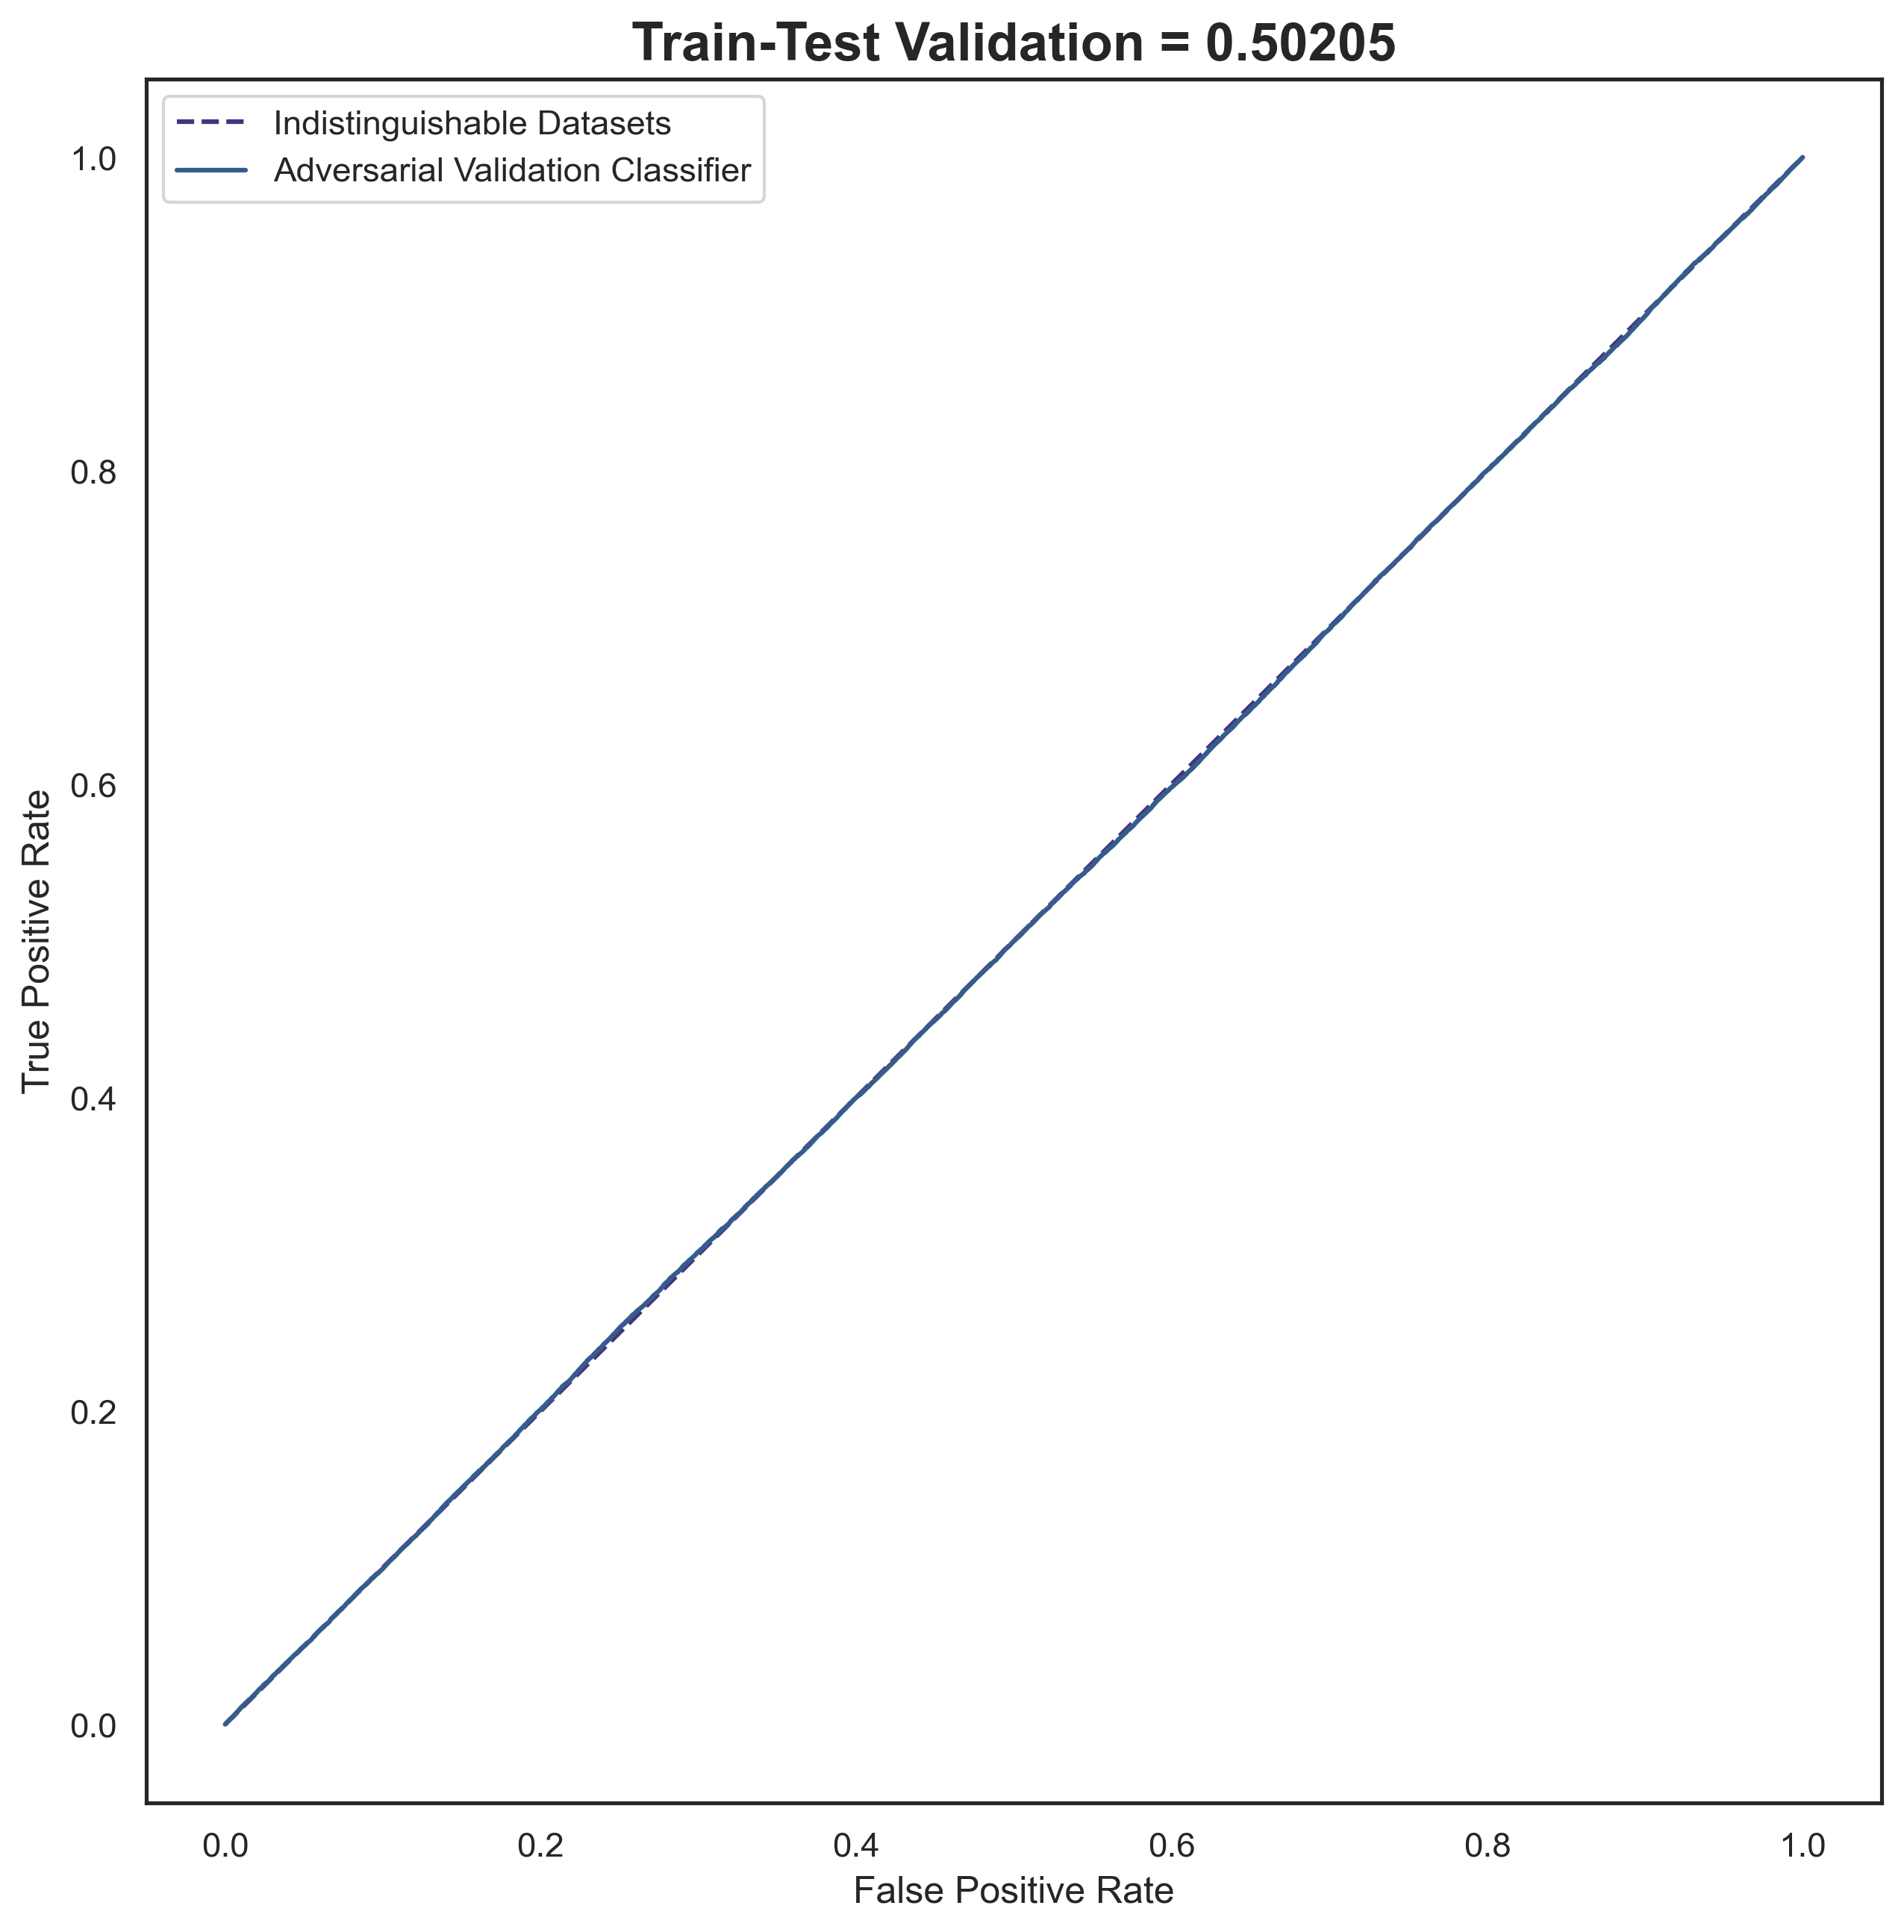

In [31]:
adversarial_validation()

## Distribution of Numerical Features

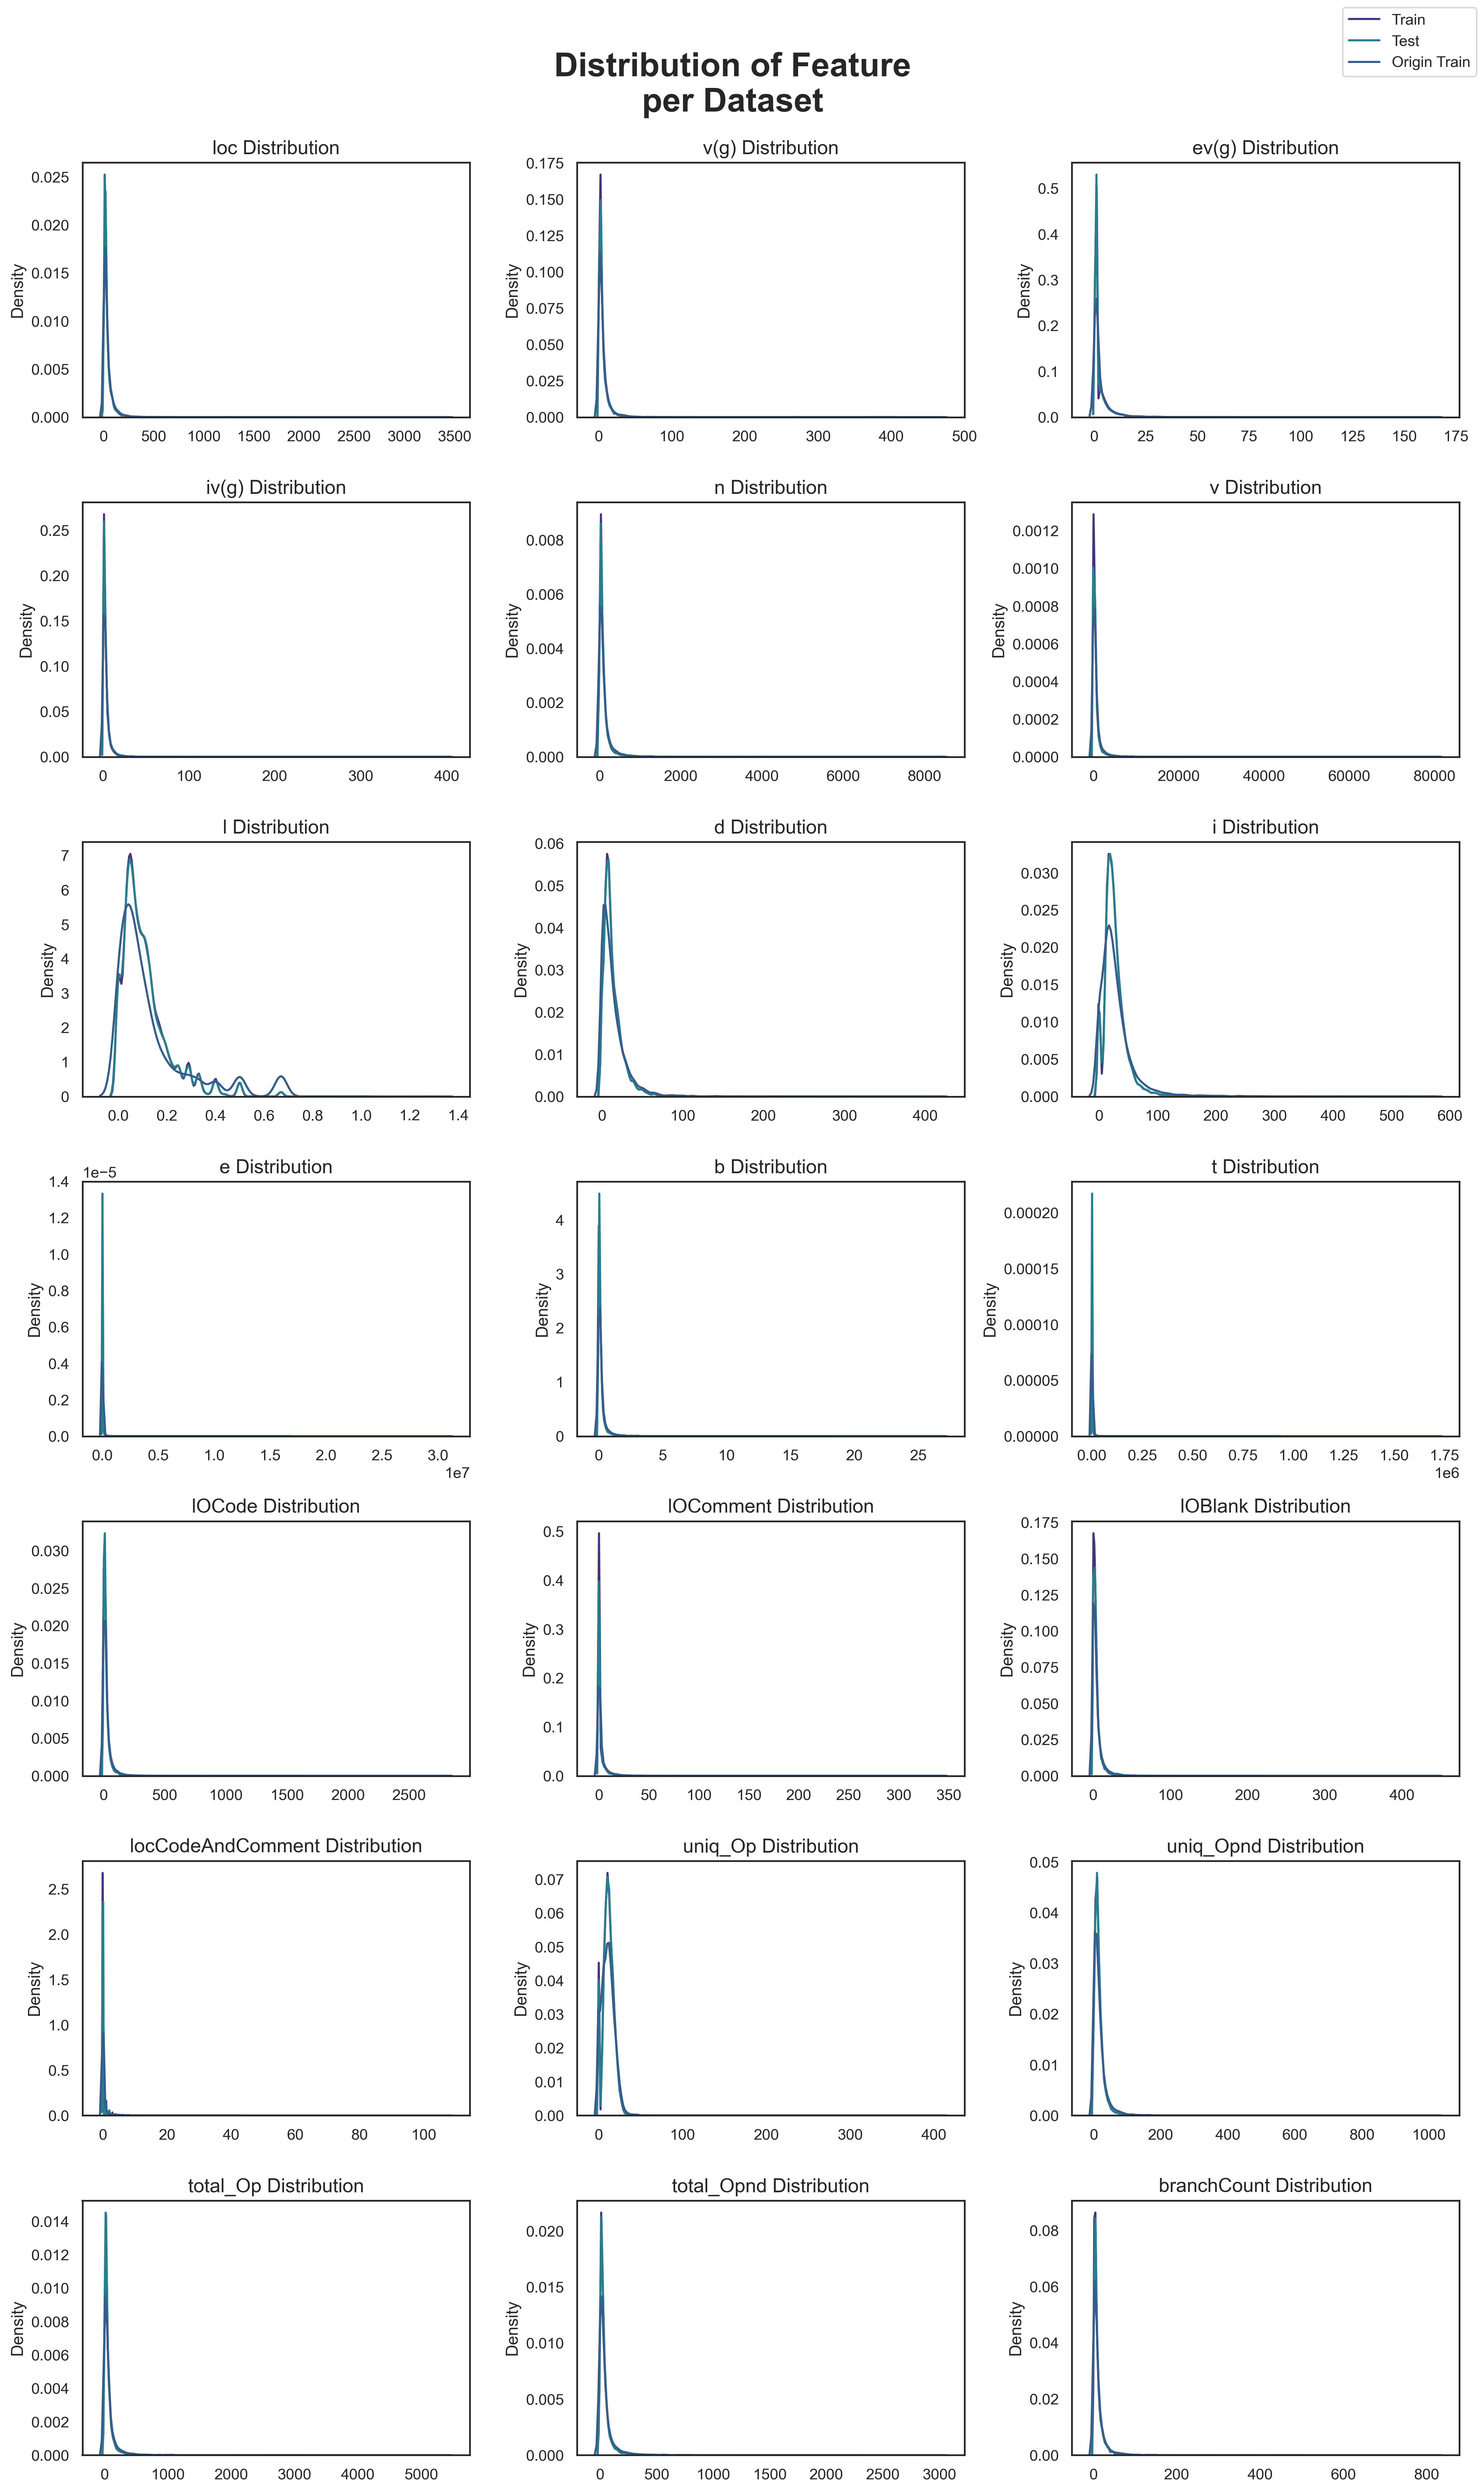

In [33]:
fig, ax = plt.subplots(7, 3, figsize=(15,25), dpi=300)
ax = ax.flatten()

for i, column in enumerate(list(test)):

    sns.kdeplot(train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal[2], warn_singular=False)
    sns.kdeplot(origin_data[column], ax=ax[i], color=pal[1])

    ax[i].set_title(f'{column} Distribution', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test', 'Origin Train'])
plt.tight_layout()

## Target Distribution

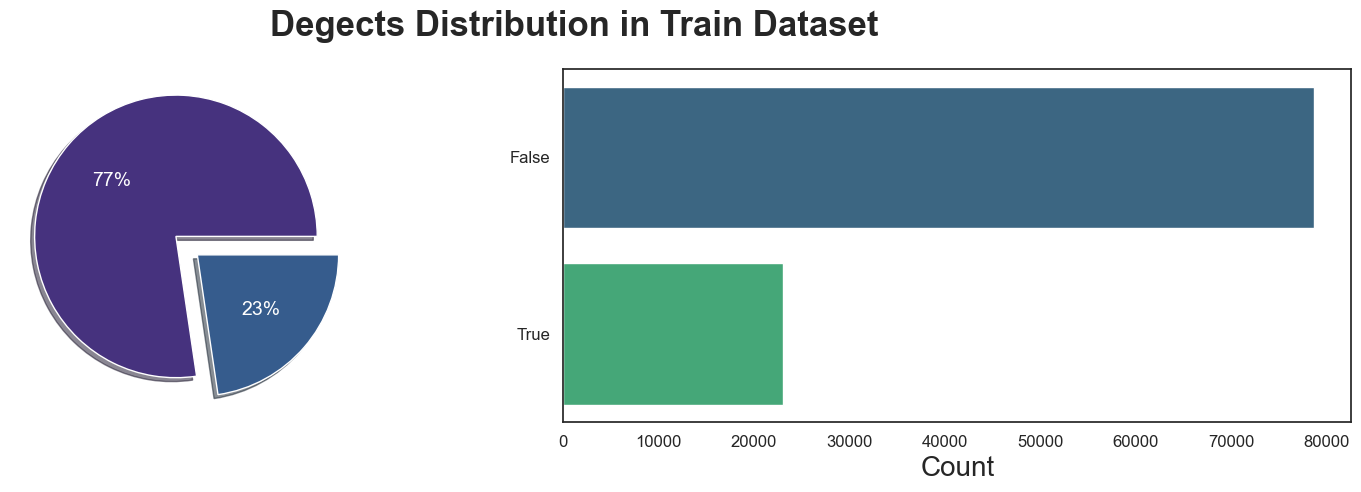

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax = ax.flatten()

ax[0].pie(
    train['defects'].value_counts(),
    shadow=True,
    explode = [.1 for i in range(train['defects'].nunique())],
    autopct = '%1.f%%',
    textprops = {'size':14, 'color':'white'}
)


sns.countplot(data = train, y = 'defects', ax=ax[1], palette='viridis', order=train['defects'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle('Degects Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

## Correaltion

In [40]:
def heatmap(dataset, label=None):
    corr = dataset.corr(method='spearman')
    plt.figure(figsize=(15,15), dpi=300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap='viridis', annot=True, annot_kws={'size':7})
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize=25, weight='bold')
    plt.show()

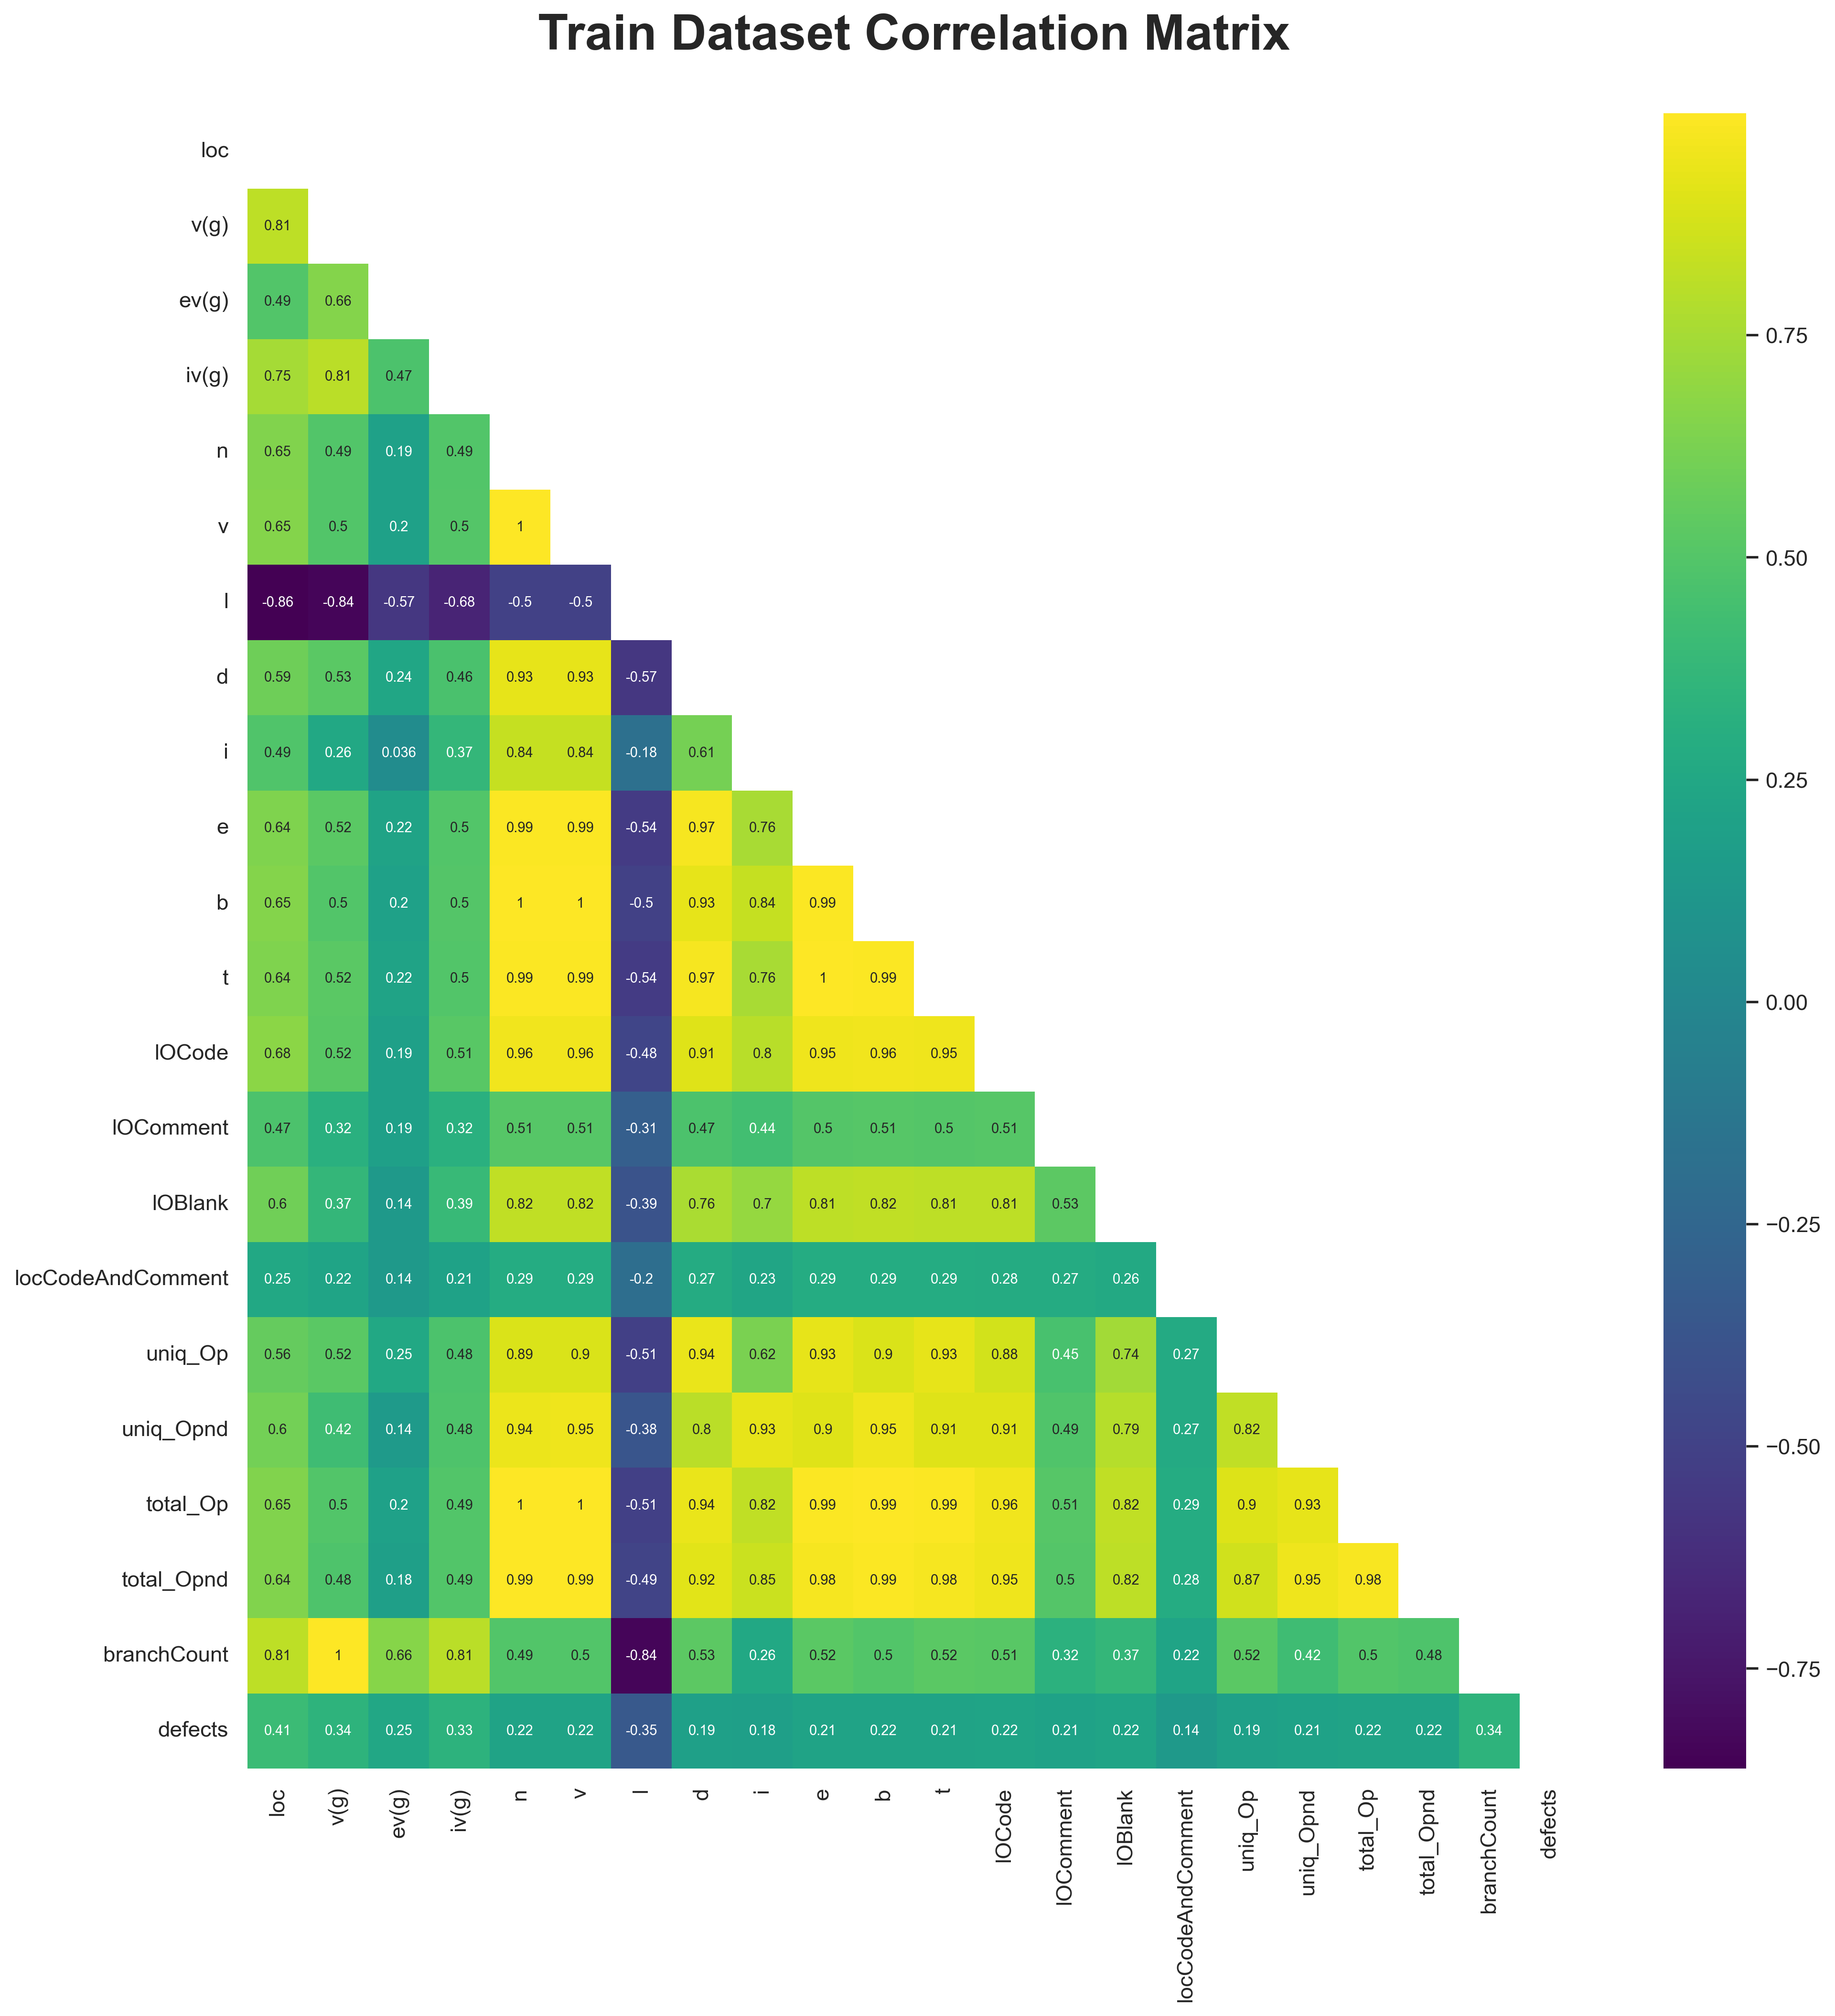

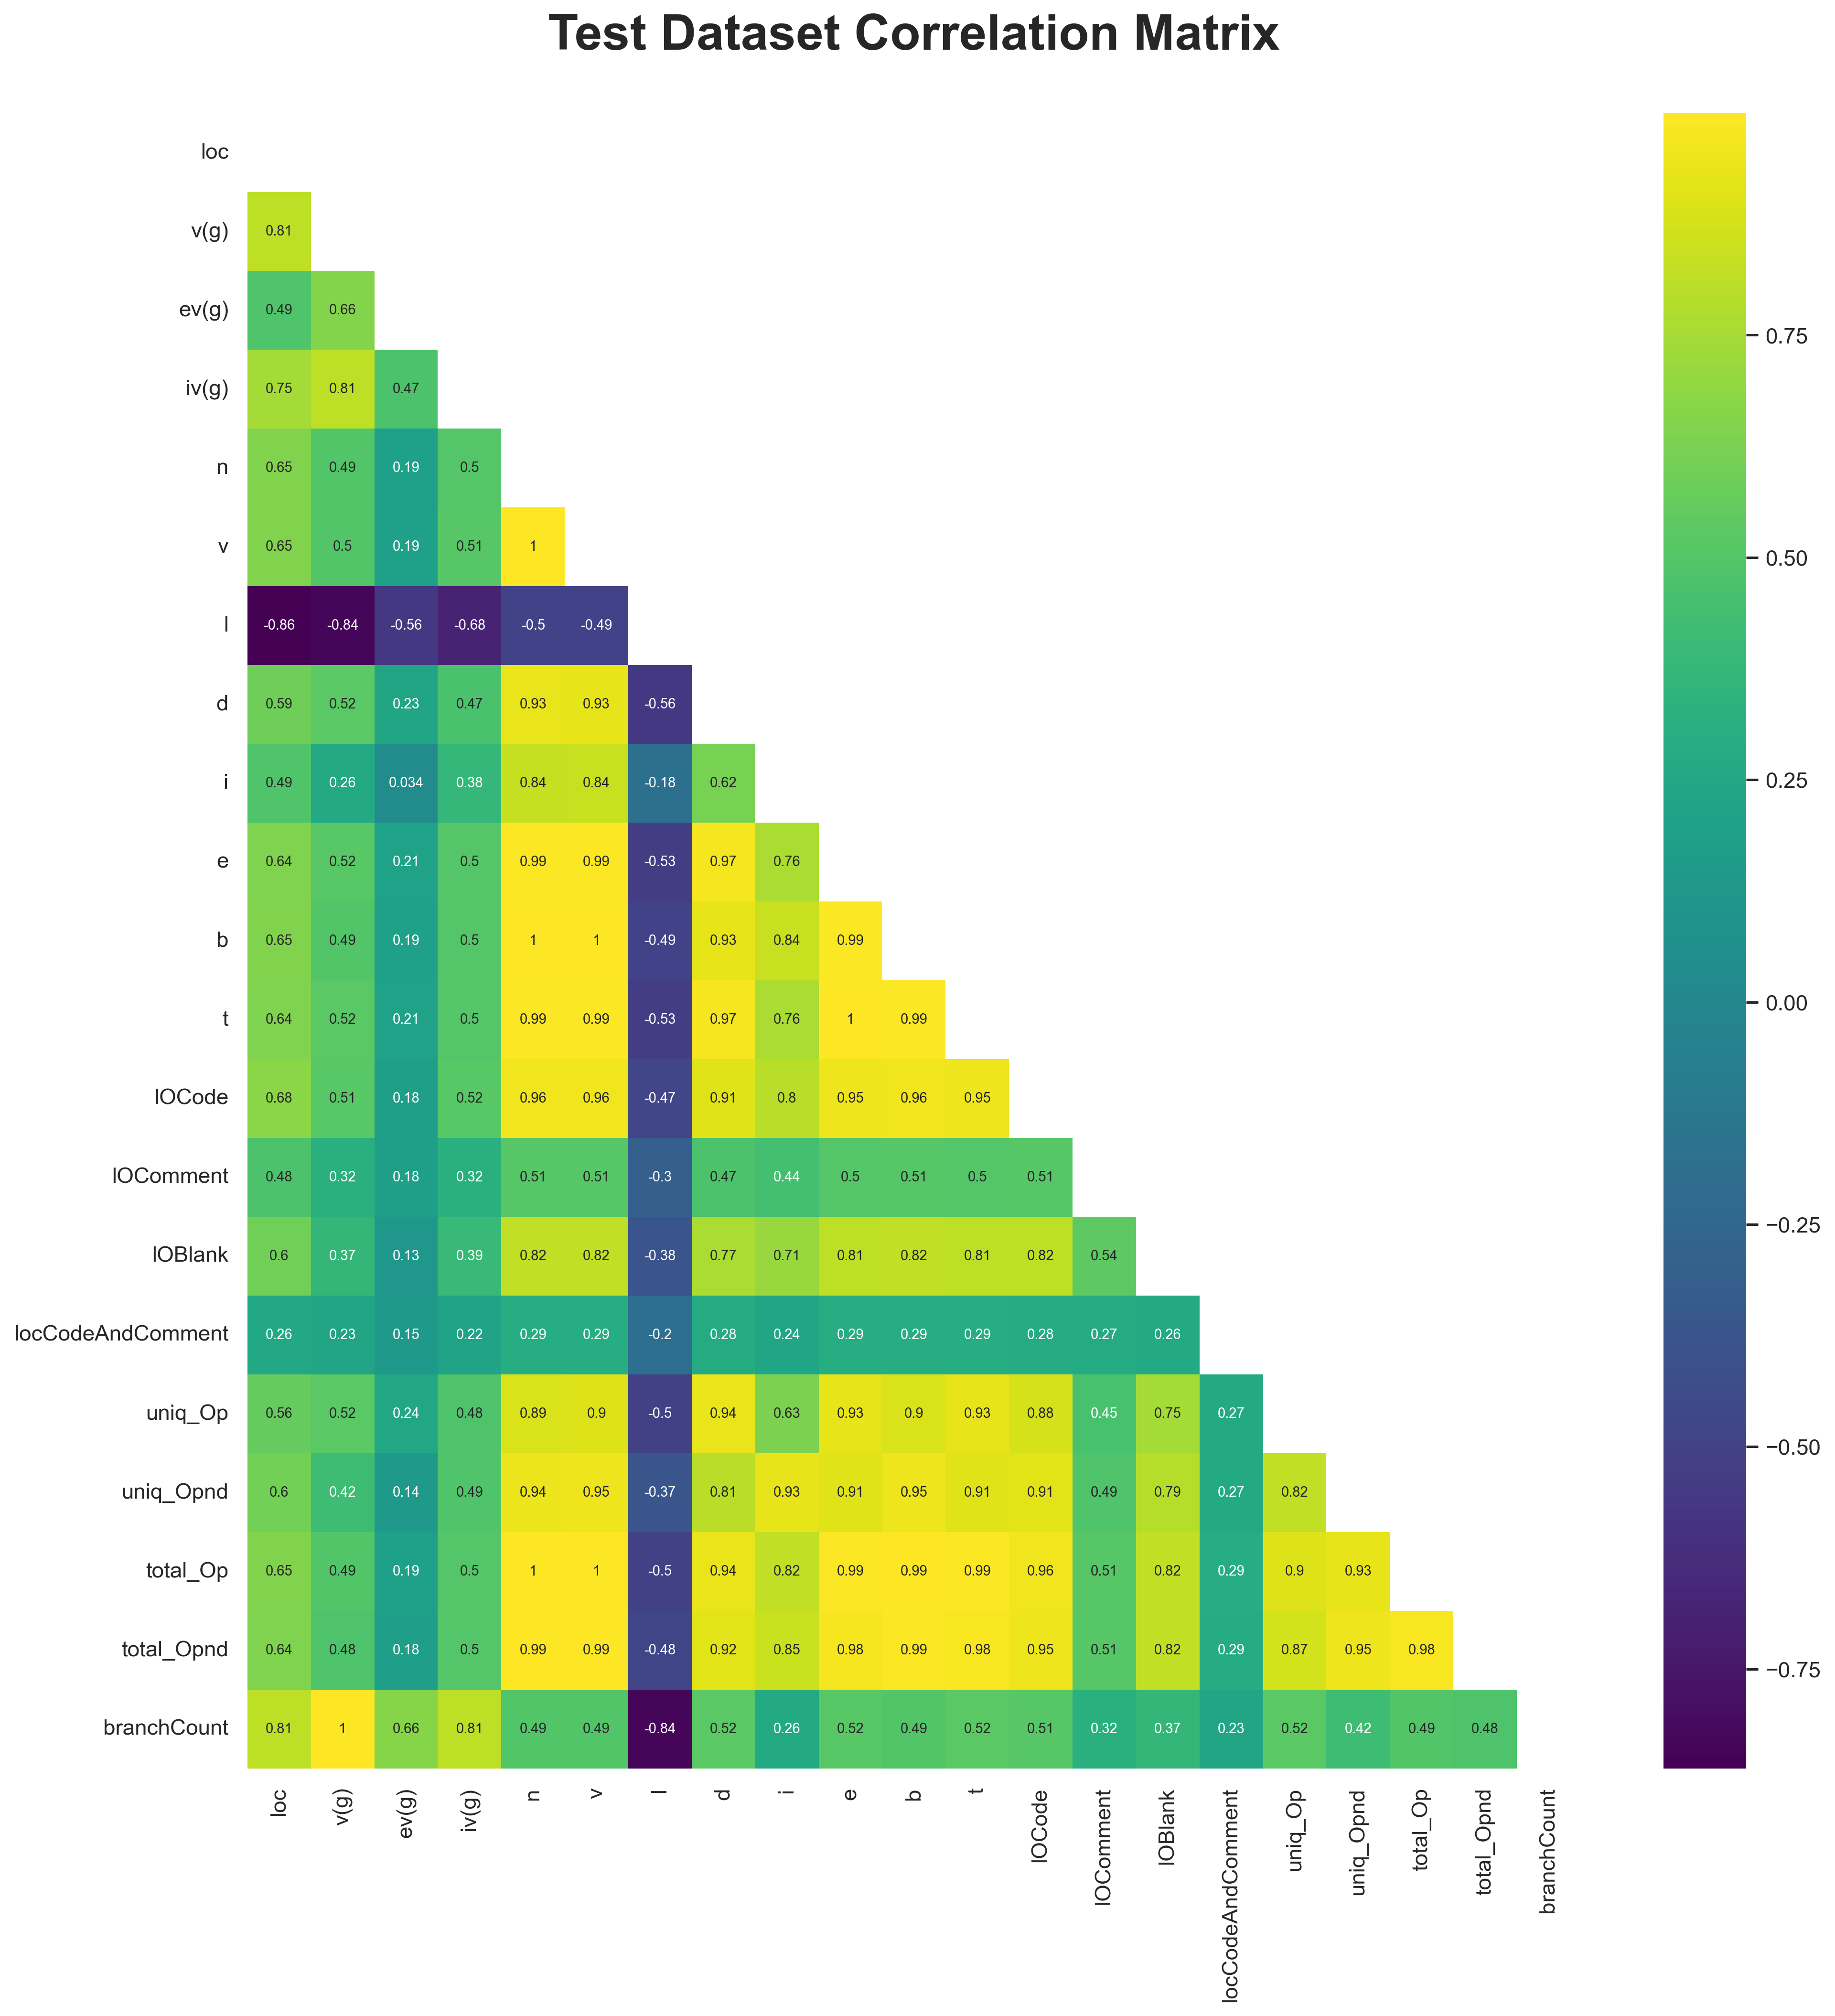

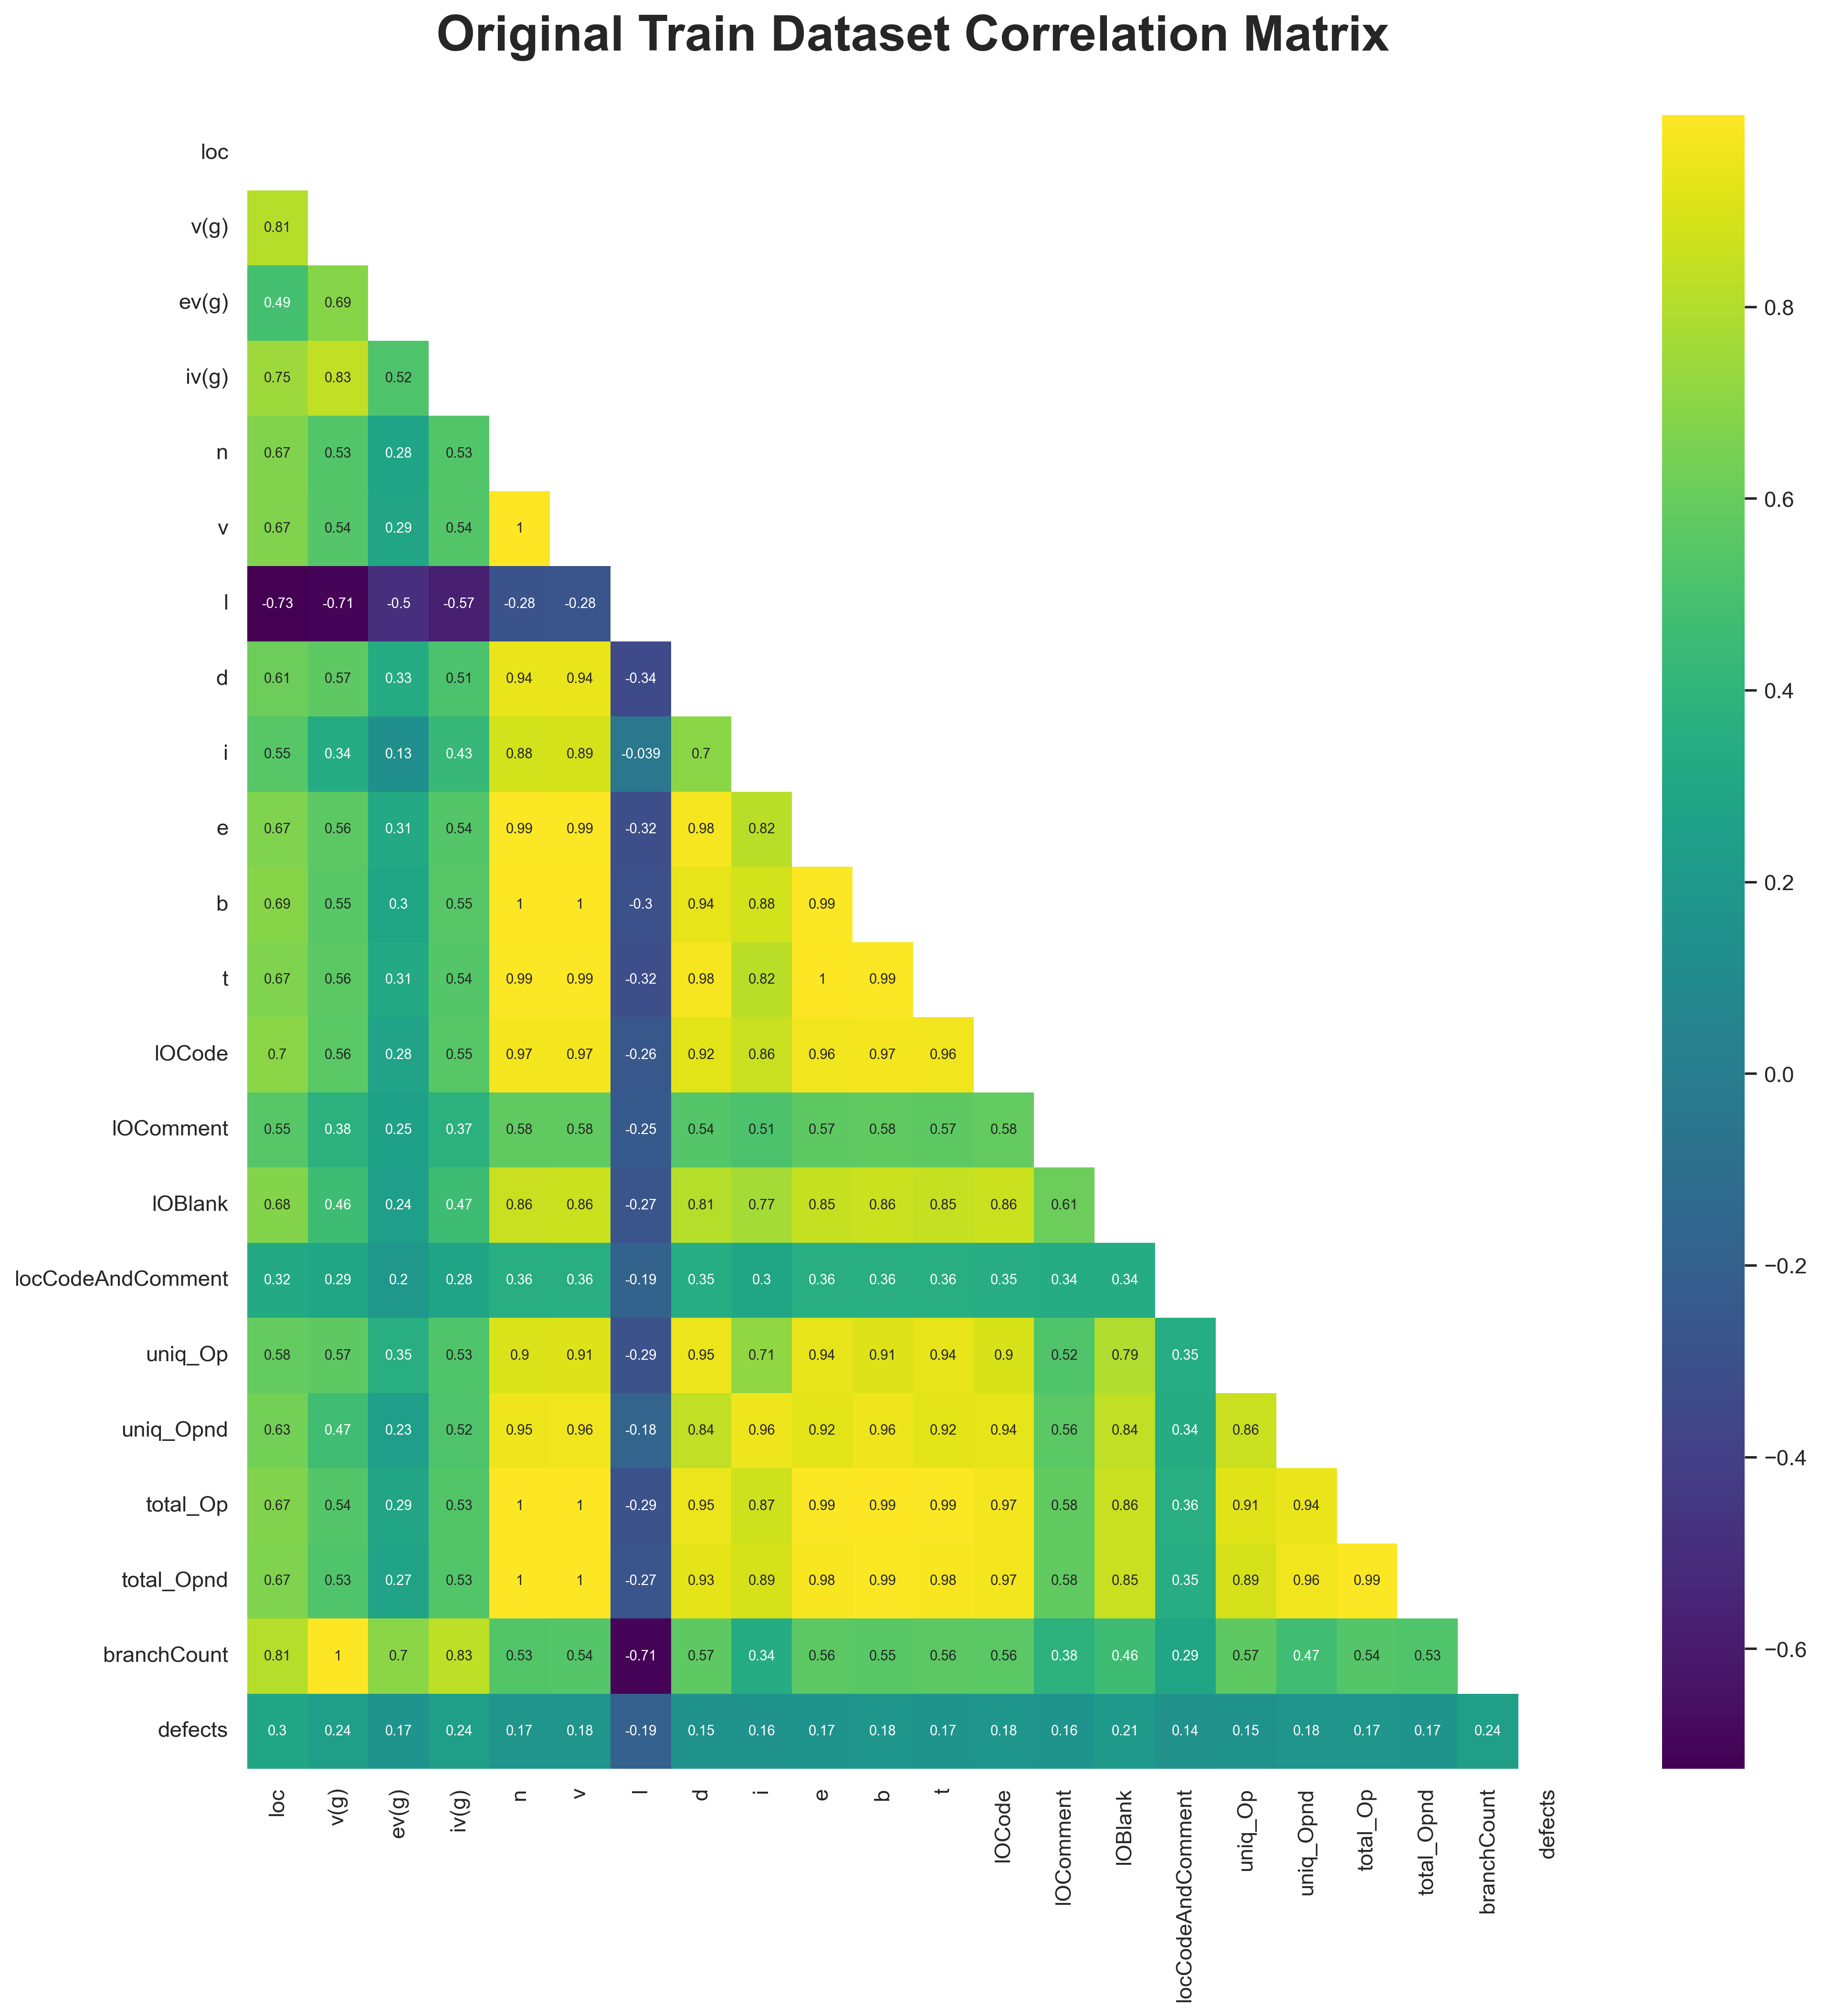

In [41]:
heatmap(train, 'Train')
heatmap(test, 'Test')
heatmap(origin_data, 'Original Train')

## Hierarchial Clustering

In [42]:
def distance(data, label=''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1-abs(corr)), 'complete')

    plt.figure(figsize=(10,8), dpi=300)
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', size=20, weight='bold')
    plt.show()

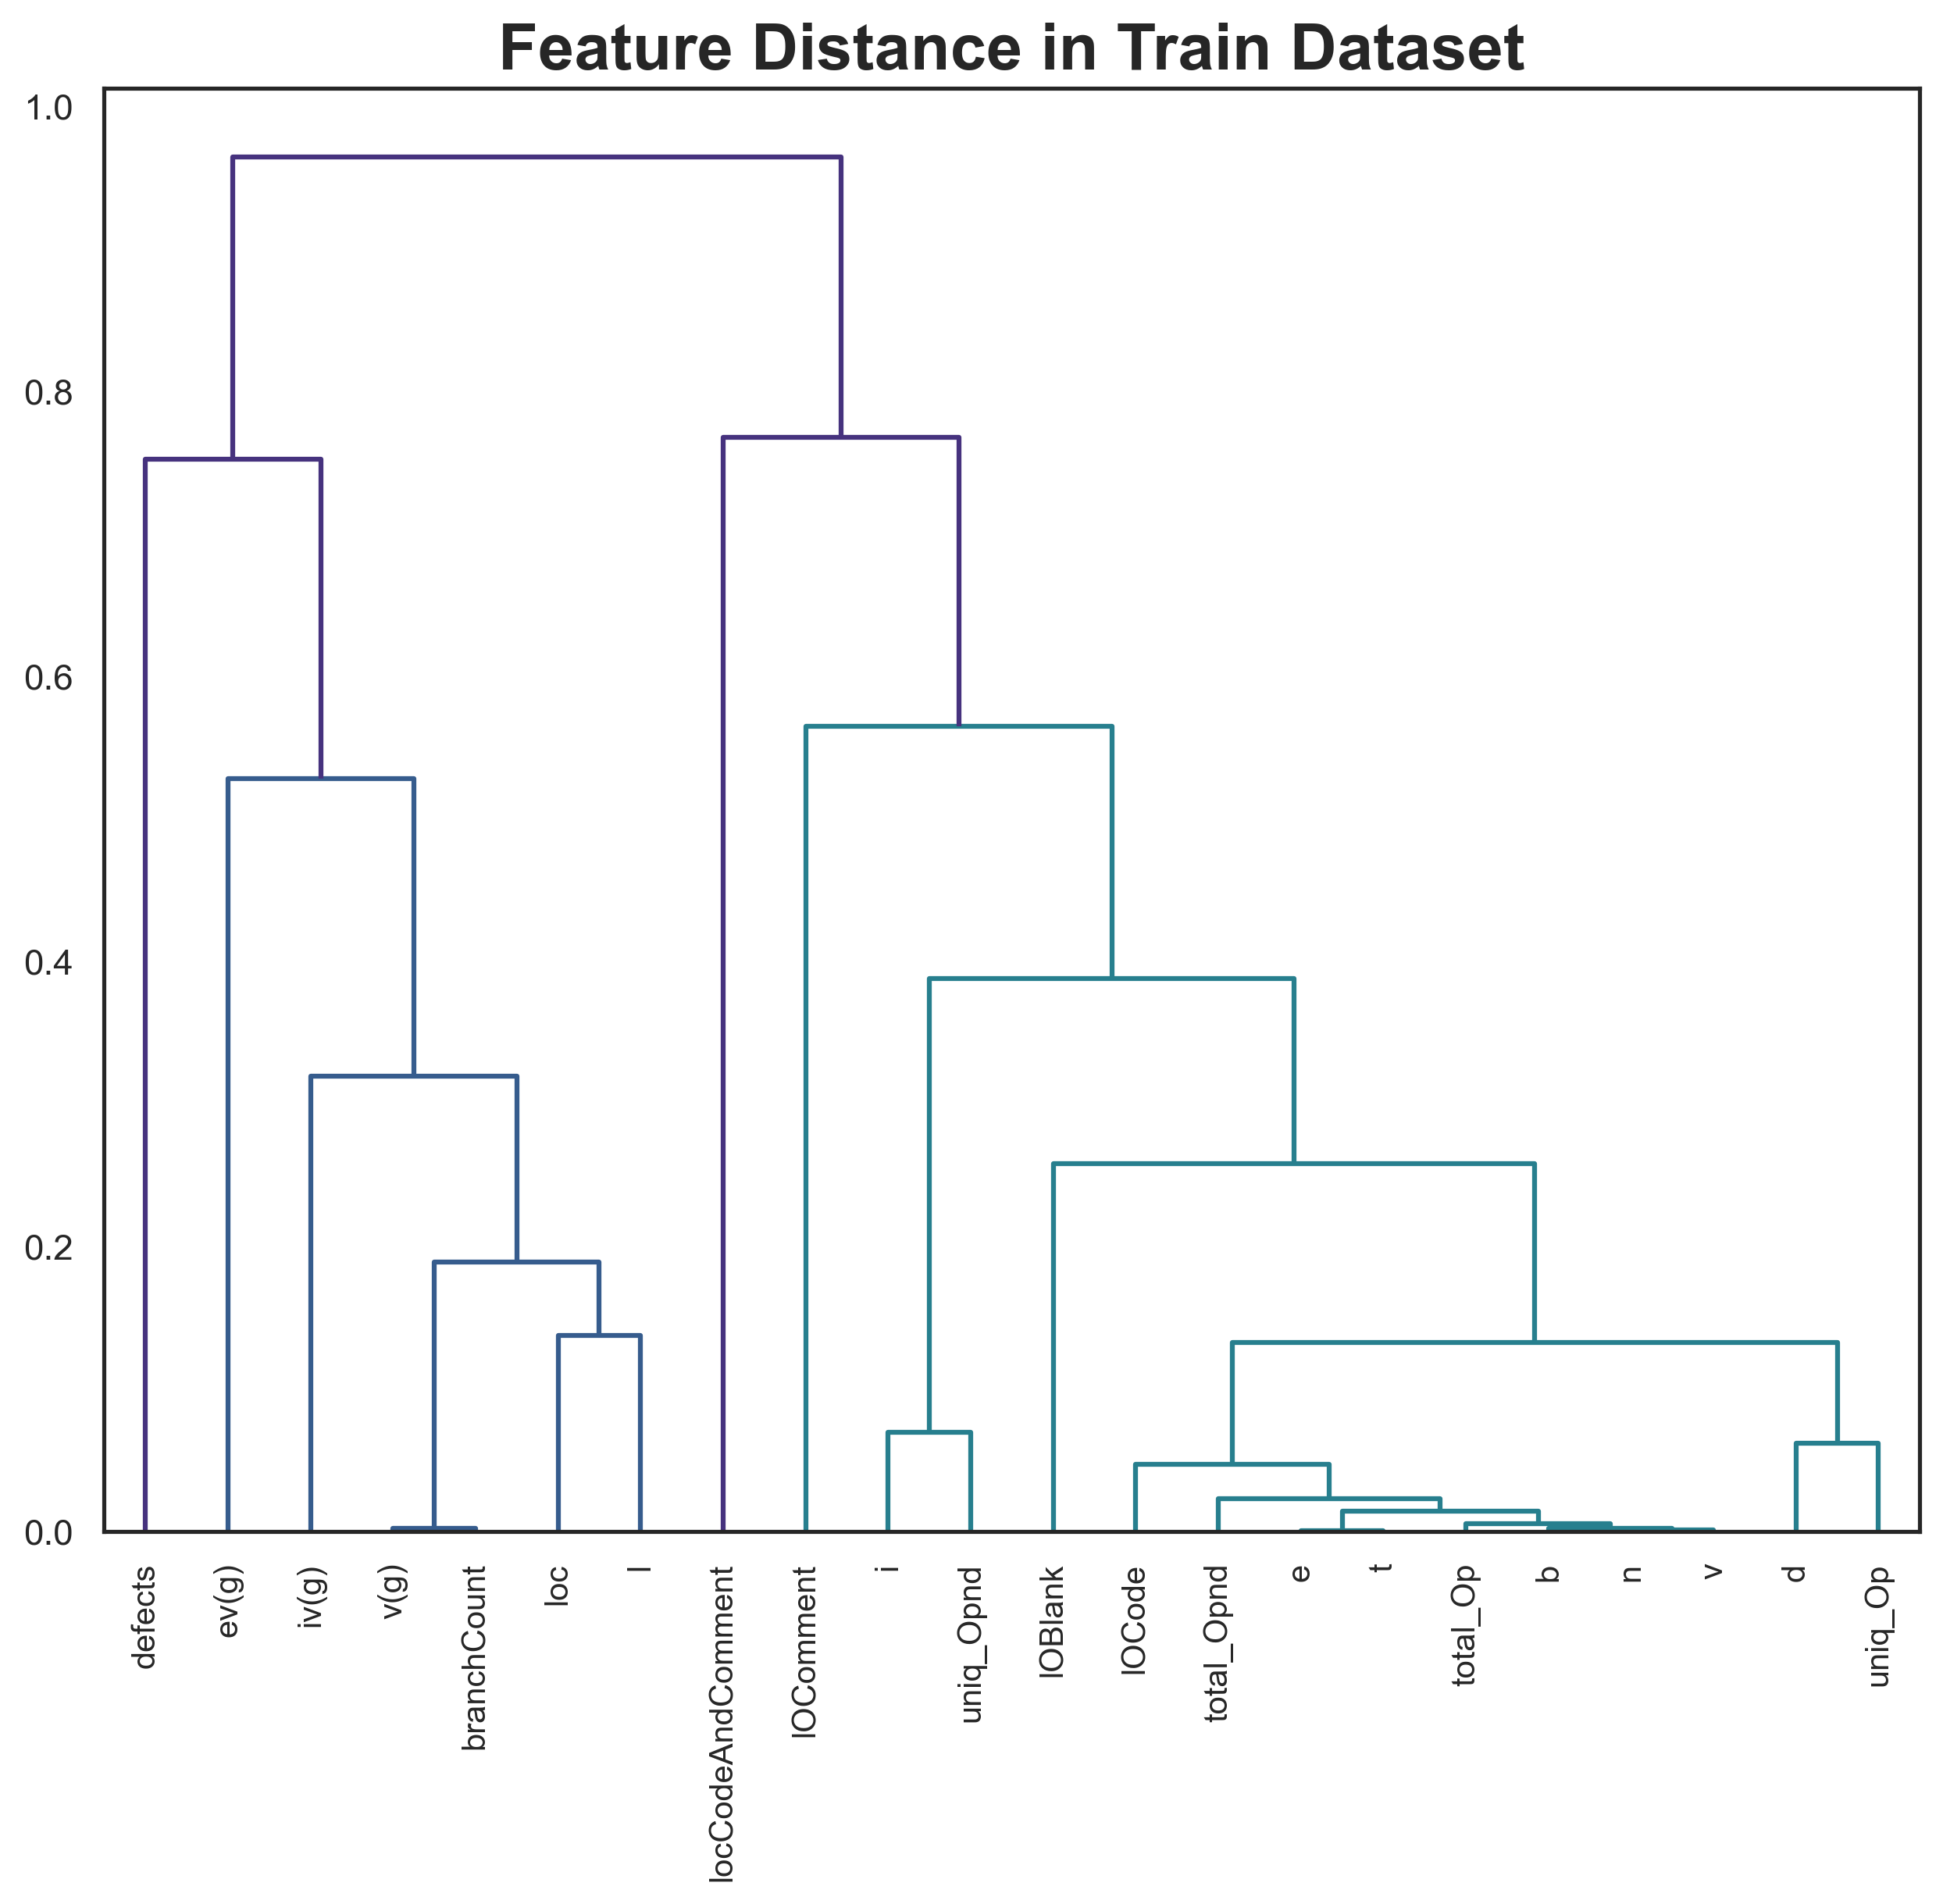

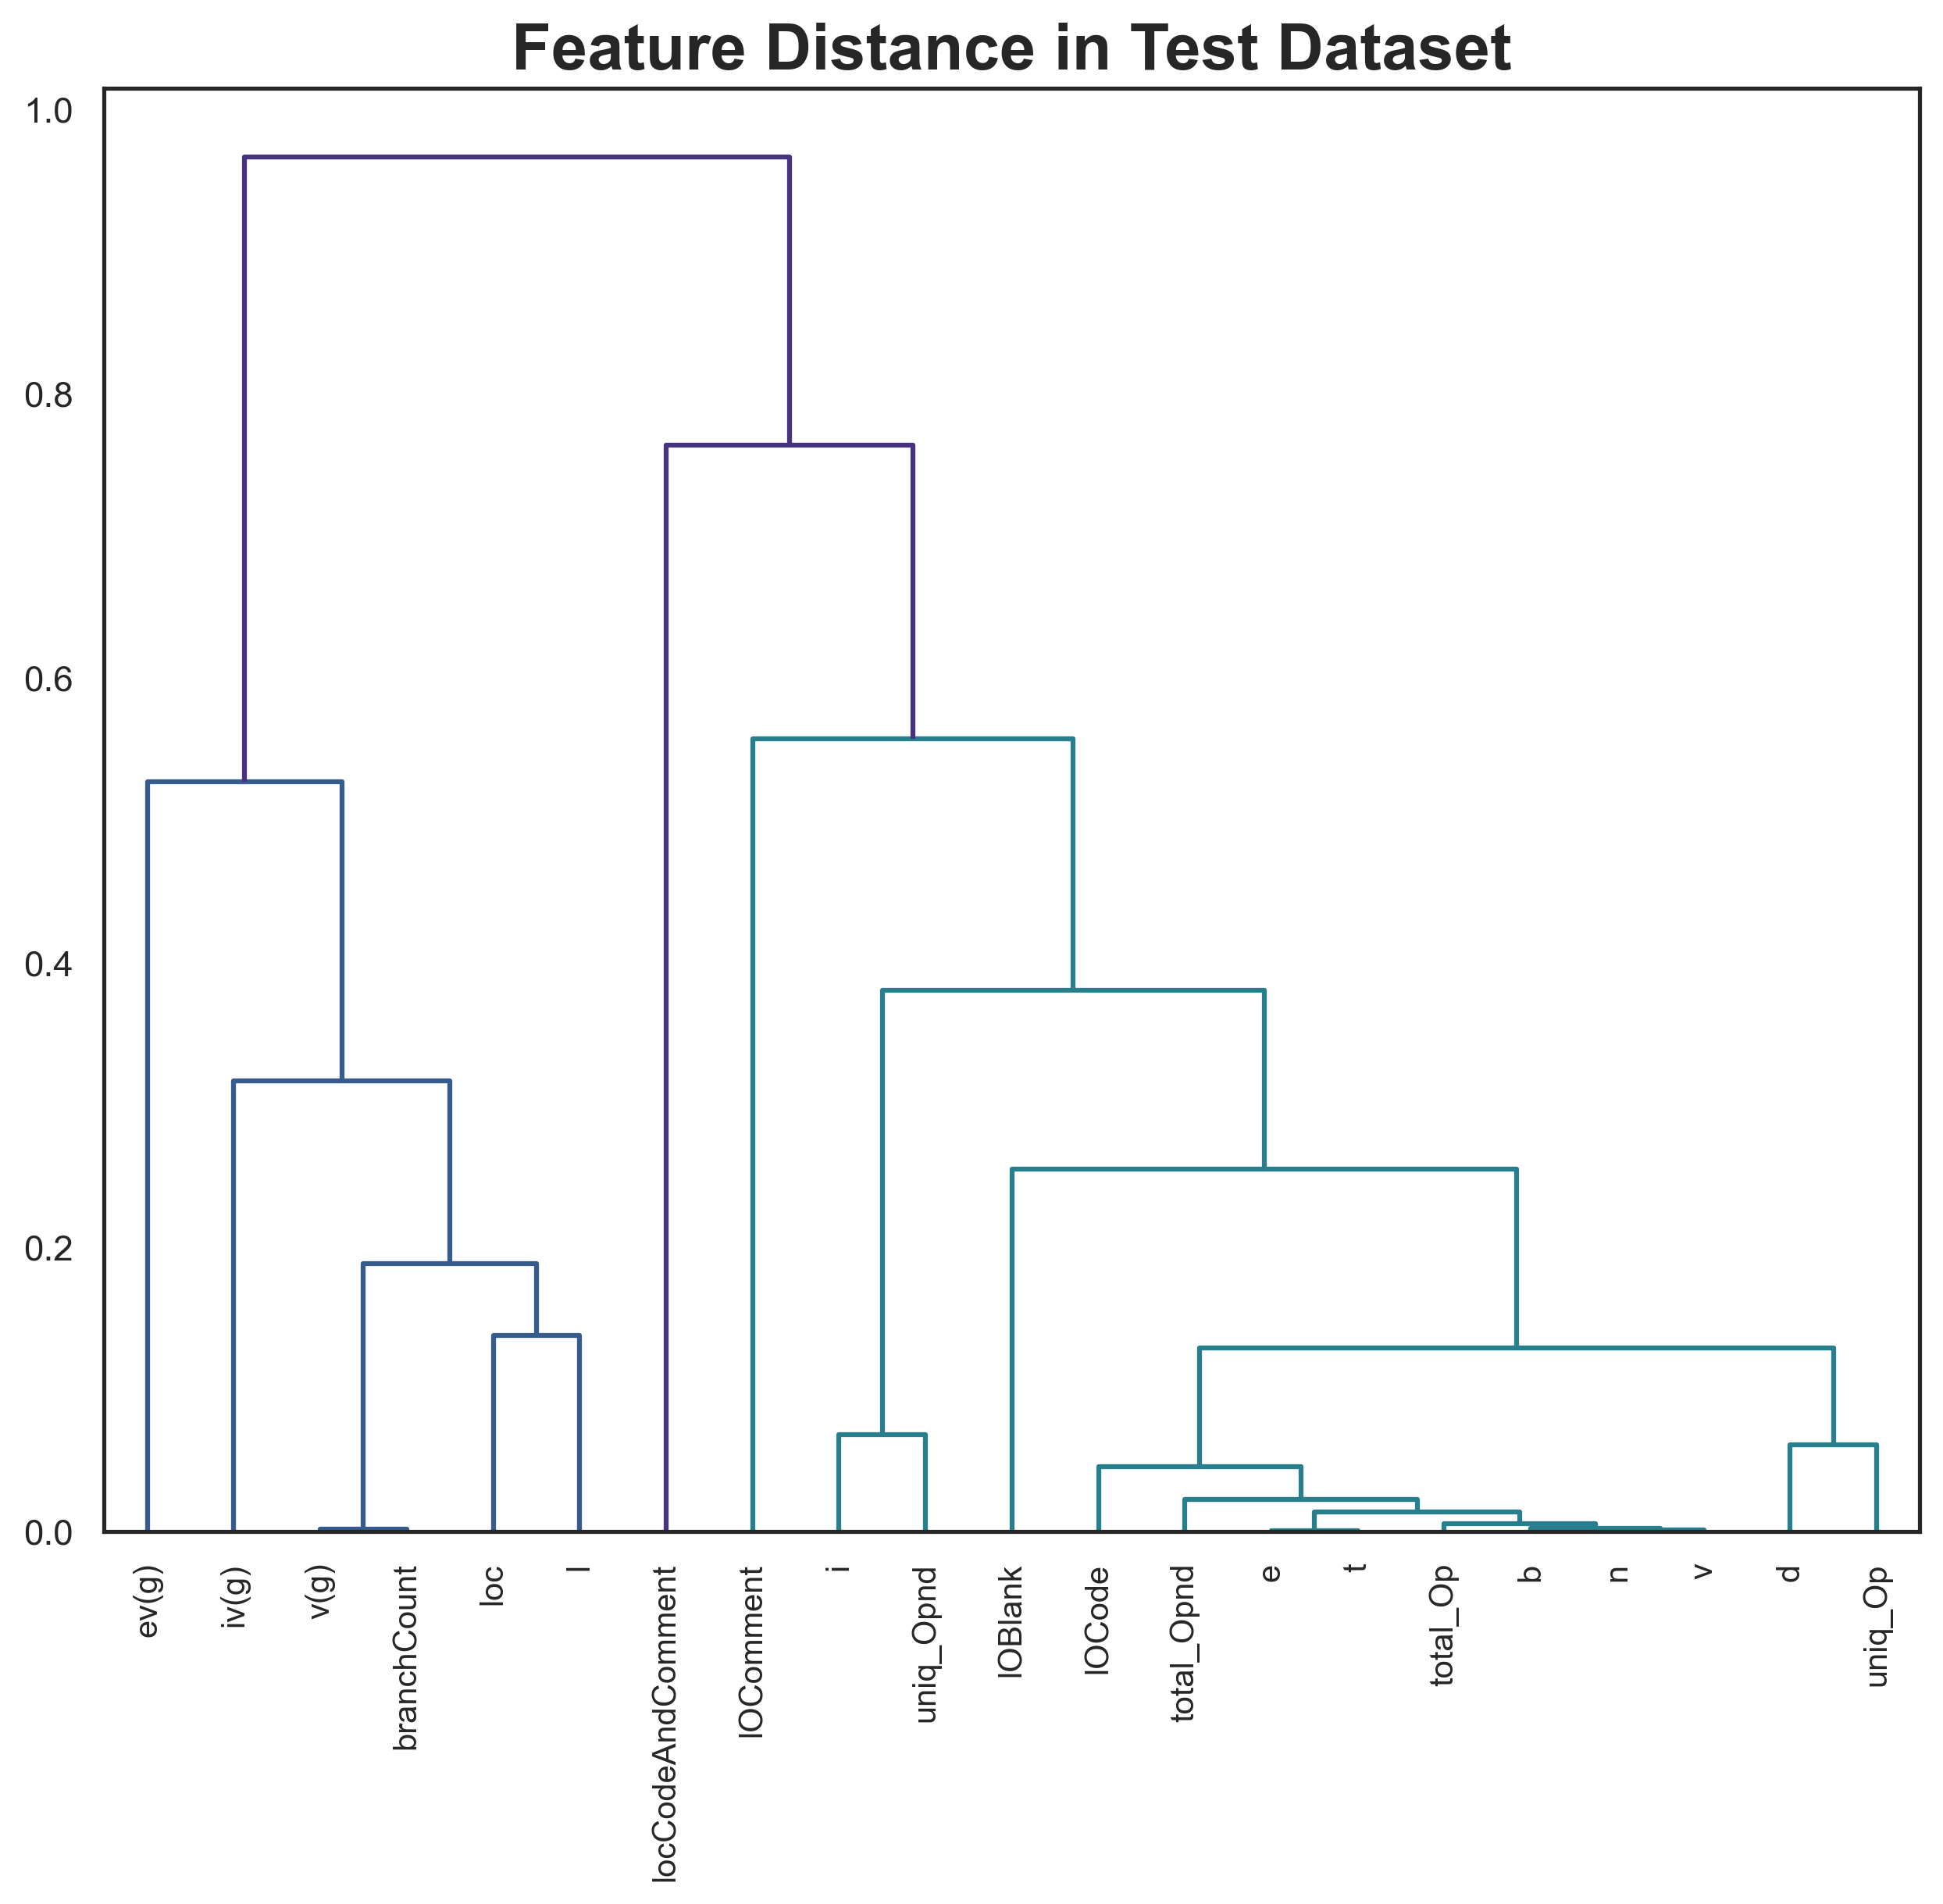

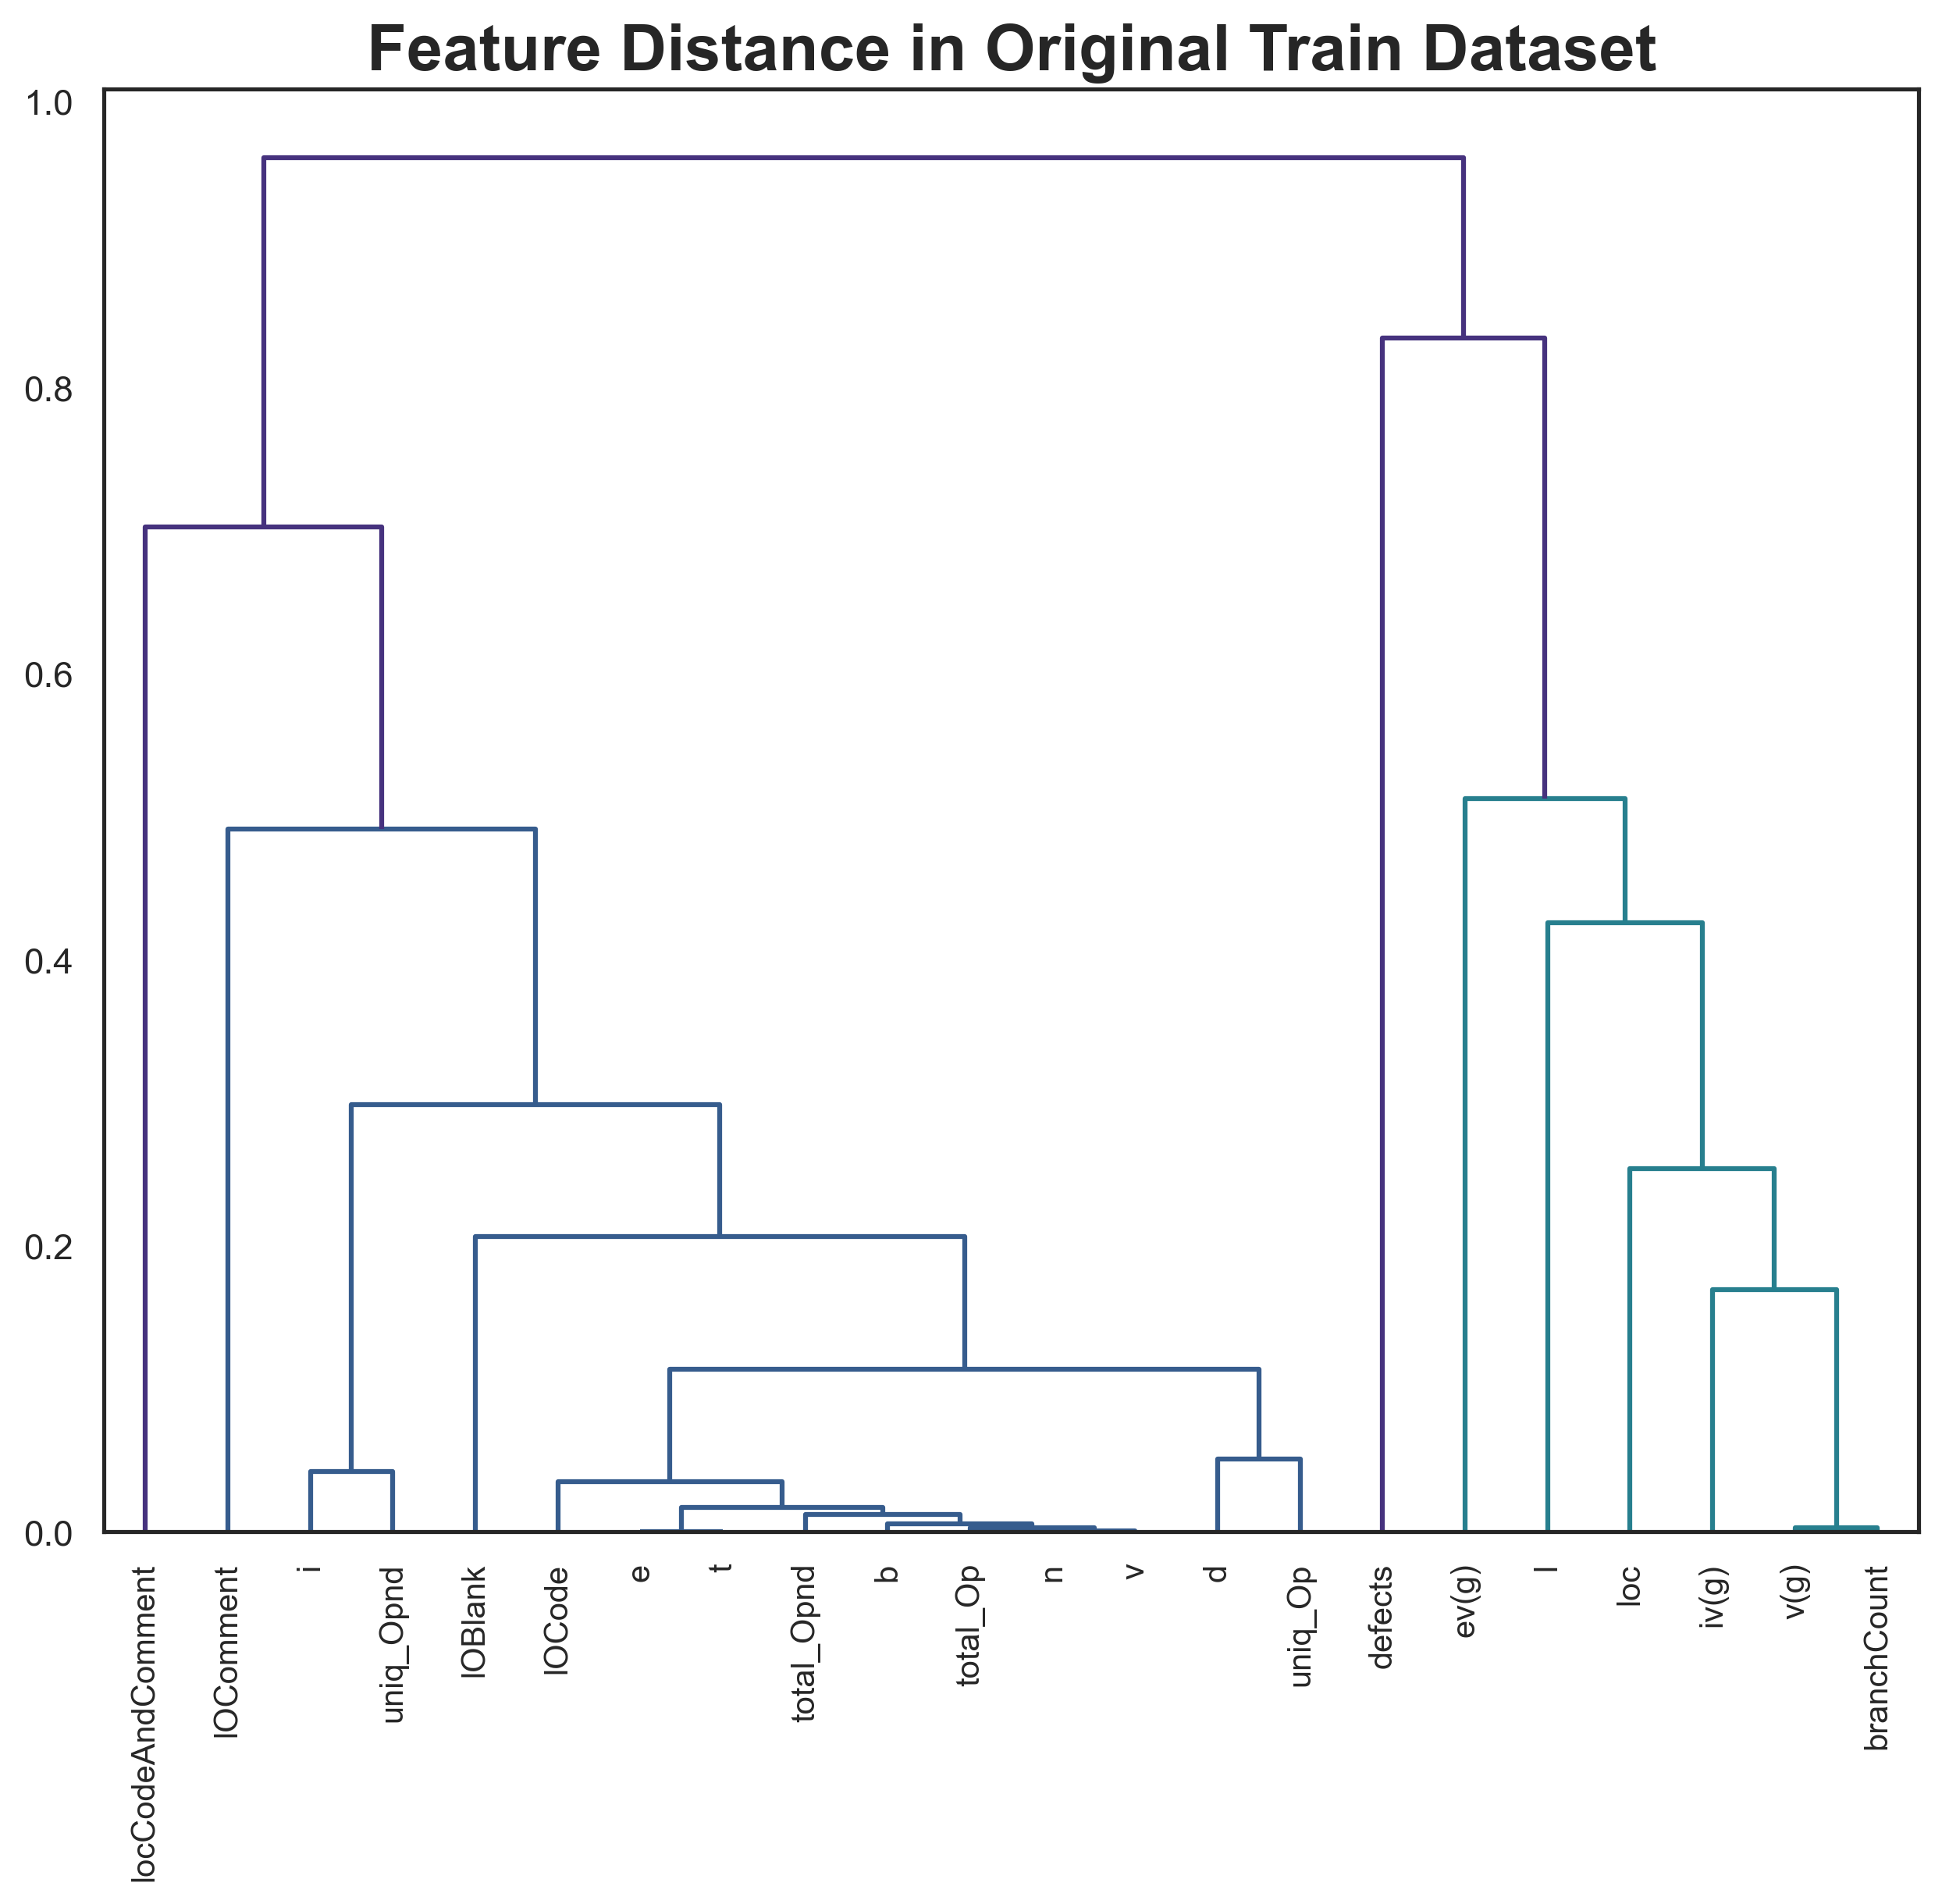

In [44]:
distance(train, 'Train')
distance(test, 'Test')
distance(origin_data, 'Original Train')

## Preparation

In [45]:
X = pd.concat([train, origin_data])
y = X.pop('defects')

seed = 42
splits = 5
skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)
np.random.seed(seed)

## Model Cross Validation

In [49]:
def cross_val_score(estimator, cv=skf, label='', include_original=False):

    X = train.copy()
    y = X.pop('defects')

    # initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    # train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []

    # training model, predicting prognosis probability, and evaluation metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        if include_original:
            X_train = pd.concat([X_train, origin_data.drop('defects', axis = 1)])
            y_train = pd.concat([y_train, origin_data.defects])
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                  
        val_predictions[val_idx] += val_preds
        
        #evaluate model for a fold
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [54]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state=seed, max_iter=1000000)),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('knn',KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state=seed)),
    ('et', ExtraTreesClassifier(random_state=seed)),
    ('xgb', XGBClassifier(random_state=seed)),
    ('lgb', LGBMClassifier(random_state=seed)),
    ('dart', LGBMClassifier(random_state=seed, boosting_type='dart')),
    ('cb', CatBoostClassifier(random_state=seed, verbose=0)),
    ('gb', GradientBoostingClassifier(random_state=seed)),
    ('hgb', HistGradientBoostingClassifier(random_state=seed)),
]

for (label, model) in models:
    score_list[label], oof_list[label] = cross_val_score(
        make_pipeline(SimpleImputer(), model),
        label = label,
        include_original=True
    )

Val Score: 0.65439 ± 0.03237 | Train Score: 0.64764 ± 0.03120 | log
Val Score: 0.77764 ± 0.00345 | Train Score: 0.76936 ± 0.00097 | lda
Val Score: 0.76963 ± 0.00439 | Train Score: 0.75897 ± 0.00046 | gnb
Val Score: 0.68332 ± 0.00334 | Train Score: 0.67340 ± 0.00073 | bnb
Val Score: 0.70886 ± 0.00347 | Train Score: 0.87489 ± 0.00094 | knn
Val Score: 0.76402 ± 0.00320 | Train Score: 0.99930 ± 0.00003 | rf
Val Score: 0.75292 ± 0.00280 | Train Score: 0.99994 ± 0.00000 | et
Val Score: 0.78392 ± 0.00360 | Train Score: 0.83896 ± 0.00195 | xgb
[LightGBM] [Info] Number of positive: 20557, number of negative: 71738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 92295, number of used features: 21
[LightGBM] [Info] [binary:BoostFro

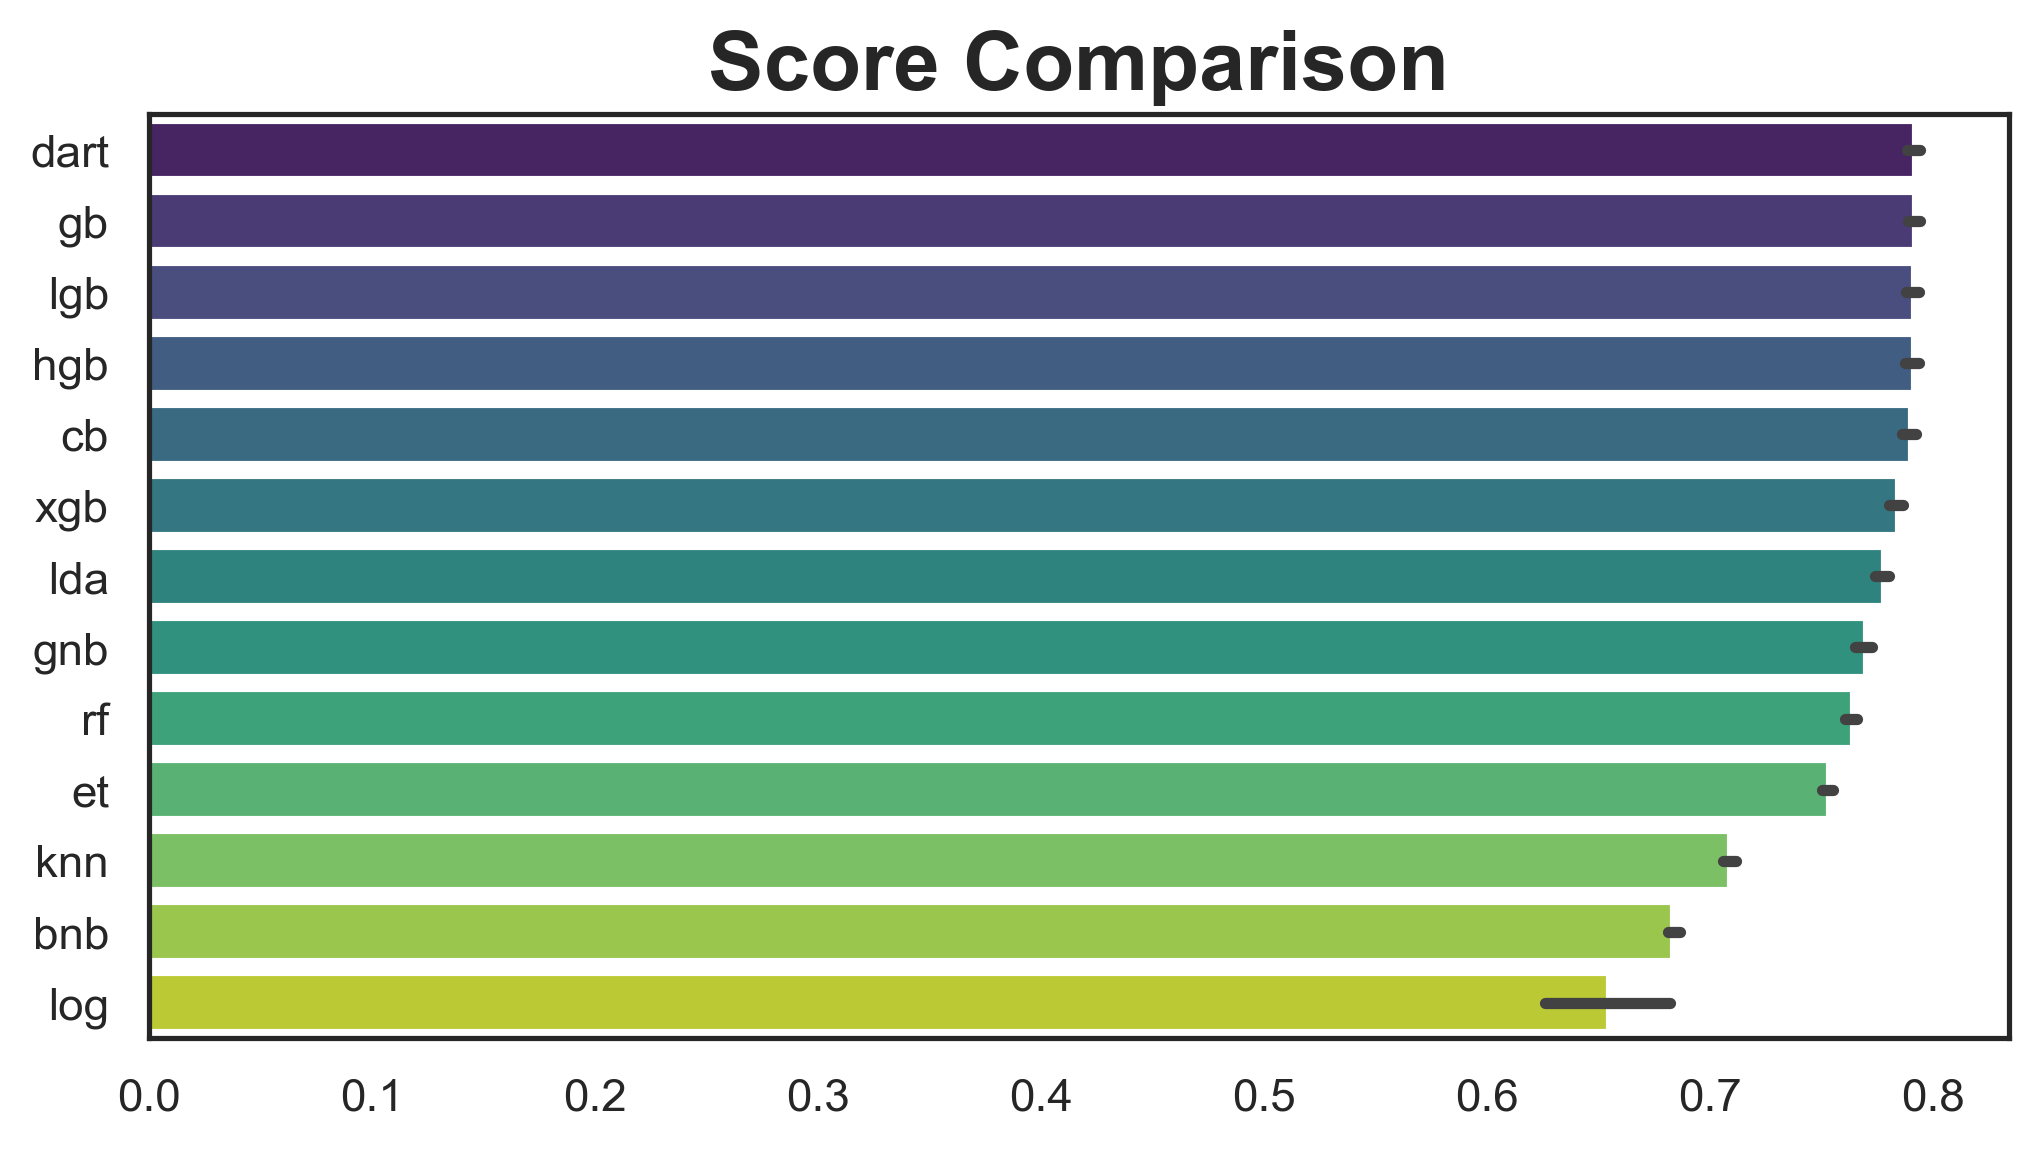

In [56]:
plt.figure(figsize=(8,4), dpi=300)
sns.barplot(data=score_list.reindex((-1*score_list).mean().sort_values().index, axis=1), palette='viridis', orient='h')
plt.title('Score Comparison', weight='bold', size=20)
plt.show()

## Voting Ensemble

In [59]:
weights = RidgeClassifier(random_state=seed).fit(oof_list, train.defects).coef_[0]
pd.DataFrame(weights, index=list(oof_list), columns=['weight per model'])

weight per model
log          -0.037959
lda           0.062658
gnb           0.013555
bnb           0.001657
knn           0.050528
rf            0.107990
et           -0.119049
xgb           0.009058
lgb           0.228370
dart          0.726561
cb            0.256603
gb            0.647764
hgb           0.213646

In [60]:
voter = VotingClassifier(models, weights=weights, voting='soft')
_ = cross_val_score(
    make_pipeline(SimpleImputer(), voter),
    include_original=True
)

[LightGBM] [Info] Number of positive: 20557, number of negative: 71738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 92295, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222731 -> initscore=-1.249819
[LightGBM] [Info] Start training from score -1.249819
[LightGBM] [Info] Number of positive: 20557, number of negative: 71738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 92295, number of used features: 21
[LightGBM] [Info] 

## Prediction and Submission

In [61]:
model = make_pipeline(
    SimpleImputer(),
    voter
)

model.fit(X, y)

[LightGBM] [Info] Number of positive: 25170, number of negative: 87478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 112648, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223439 -> initscore=-1.245735
[LightGBM] [Info] Start training from score -1.245735
[LightGBM] [Info] Number of positive: 25170, number of negative: 87478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 112648, number of used features: 21
[LightGBM] [Info

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('log',
                                               LogisticRegression(max_iter=1000000,
                                                                  random_state=42)),
                                              ('lda',
                                               LinearDiscriminantAnalysis()),
                                              ('gnb', GaussianNB()),
                                              ('bnb', BernoulliNB()),
                                              ('knn', KNeighborsClassifier()),
                                              ('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('et',
                                               ExtraTreesClassifier(rando...
                                                              random_state=42)),
                                              ('cb',
                                               <catboost.core.CatBoostClassifier object at 0x2a0cb2350>),
                                              ('gb',
                                               GradientBoostingClassifier(random_state=42)),
                                              ('hgb',
                                               HistGradientBoostingClassifier(random_state=42))],
                                  voting='soft',
                                  weights=array([-0.0379594 ,  0.06265793,  0.01355524,  0.00165664,  0.05052813,
        0.10799014, -0.11904856,  0.00905764,  0.22837019,  0.72656073,
        0.25660279,  0.64776422,  0.21364573])))])

In [63]:
submission = test.copy()
submission['defects'] = model.predict_proba(submission)[:, 1]

submission.defects.to_csv("231016_submission.csv")